## CATs
This notebook implements CATs in the form discussed in the paper, i.e.,
1. Lorenz'96 model with the reference truth possessing both large and small scales and standard parameter combination for chaotic behaviour. The imperfect model space uses large scales and parameterized small scales.
2. Analog forecasting is only used for providing adjoint. The actual imperfect model is used for providing forecasts.

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import tensorflow_probability as tfp
import gc

##  Lorenz'96 Testcase:

The reference model is a two-level system of ODEs for $K$ large-scale
variables, each with $J$ small-scale components. The evolution equations for
large- and small-scale components ($X_k$s and $Y_j$s, respectively) are given as,

<h3>$\dfrac{dX_k}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F - hc\overline{Y}_k$ </h3>
<h3>$\dfrac{1}{c}\dfrac{dY_{j,k}}{dt} = -b Y_{j+1,k}(Y_{j+2,k} - Y_{j-1,k}) - Y_{j,k} + \dfrac{h}{J}X_k $</h3>

Here $h$ is the coupling constant, $c$ is the temporal scale ratio, and $b$ is the spatial scale ratio. The imperfect model is the set of equations corresponding to the large-scale
components only, i.e.,
<h3>$\dfrac{dX_j}{dt} = -X_{k-1}(X_{k-2} - X_{k+1}) - X_k + F $ </h3>

Typical values of the involved parameters are: $K=36$, $J=10$, $h=1$, $F=10$, $c=10$, and $b=10$.   

In [2]:
def L96_twolevel(y,t,K=36,J=10,h=1,F=10,c=10,b=10):
    X = y[:K]
    Y = y[K:].reshape((J,K))
    dydt = np.zeros(y.shape)
    dydt[:K] = - np.roll(X,-1)*(np.roll(X,-2)-np.roll(X,1)) - X -(h*c)*np.mean(Y,axis=0) + F
    dydt[K:] = -c*(b*np.roll(Y,(1,0))*(np.roll(Y,(2,0))-np.roll(Y,(-1,0))) + Y - (h/J)*np.tile(X,(J,1))).reshape(K*J)
    return list(dydt)

In [3]:
def L96_onelevel(y,t,F=10):
    dydt = -np.roll(y,-1)*(np.roll(y,-2)-np.roll(y,1)) - y + F
    return list(dydt)

In [4]:
def L96_onelevel_RK4(y,F=10):
    dydt = -np.roll(y,-1)*(np.roll(y,-2)-np.roll(y,1)) - y + F
    return list(dydt)

In [5]:
# params
K = 8; J = 4; F = 10
h = 1; c = 10; b = 10 # default: b=10
t0 = 0
tend = t0+1000
dt = 0.1
nt = int((tend-t0)/dt)
t = np.linspace(t0,tend,nt+1)

# initialization
np.random.seed(10)
Xinit = np.random.normal(0.25*F,0.5*F,K) # resolved

np.random.seed(20)
ss_init = np.random.normal(0,1,J*K) # unresolved
Yinit = np.append(Xinit, ss_init) # resolved + unresolved

# integrate the Lorenz models over t
# Perfect Model
args_twolevel = (K,J,h,F,c,b)
states_twolevel = odeint(L96_twolevel,Yinit,t,args=args_twolevel)

# Imperfect Model
# Here the imperfections are due to (1) the absence of small-scales, and
# (2) error in the forcing term
F_imp = 3
args_onelevel = (F_imp,)
states_onelevel = odeint(L96_onelevel,Xinit,t,args=args_onelevel)

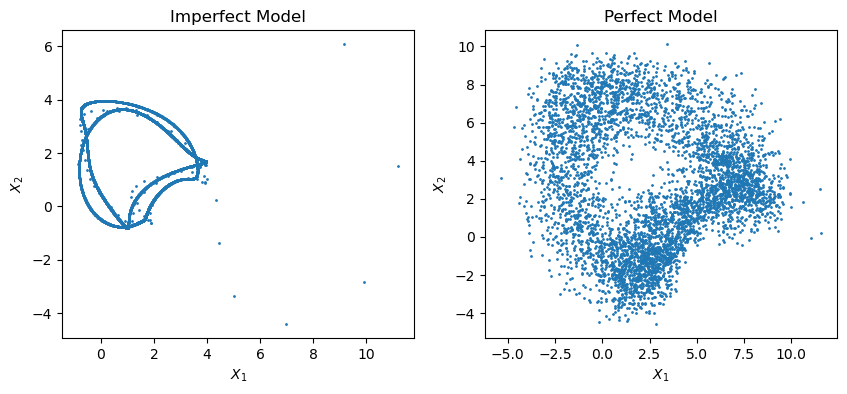

In [6]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1)
ax.scatter(states_onelevel[:5000,0],states_onelevel[:5000,1], sizes=[1])
ax.set_title('Imperfect Model'); ax.set_xlabel(r'$X_1$'); ax.set_ylabel(r'$X_2$')
ax = plt.subplot(1,2,2)
ax.scatter(states_twolevel[:5000,0],states_twolevel[:5000,1], sizes=[1])
ax.set_title('Perfect Model'); ax.set_xlabel(r'$X_1$'); ax.set_ylabel(r'$X_2$')
plt.show()

In [7]:
def RK4(xinit,t,F):
    h_loc = 0.05 # This is the size of the time step. 0.05 model time units (MTU) is about 6 hours
    states_onelevel_RK4 = np.zeros((len(t),len(xinit)))
    states_onelevel_RK4[0,:] = xinit
    x = xinit
    
    # compute number of RK4 time steps 
    nsteps =  np.diff(t)/h_loc
    
    for n in range(len(t)-1):
        nstep = round(nsteps[n])
        print('number of steps: ',nstep)
        
        for i in range(nstep):
            k1 = L96_onelevel_RK4(x,F)
            stage_2 = x + np.multiply(h_loc/2,k1)
            k2 = L96_onelevel_RK4(stage_2,F)
            stage_3 = x + np.multiply(h_loc/2,k2)
            k3 = L96_onelevel_RK4(stage_3,F)
            stage_4 = x + np.multiply(h_loc,k3)
            k4 = L96_onelevel_RK4(stage_4,F)
            update = k1 + np.multiply(2,k2) + np.multiply(2,k3) + k4
            x = x + np.multiply(h_loc/6,update)
        states_onelevel_RK4[n+1,:] = x
    
    return states_onelevel_RK4 

In [8]:
# Compare RK4 outputs against odeint for imperfect model 
states_onelevel_RK4 = RK4(Xinit,t,F_imp)

number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2


# Visualize Outputs

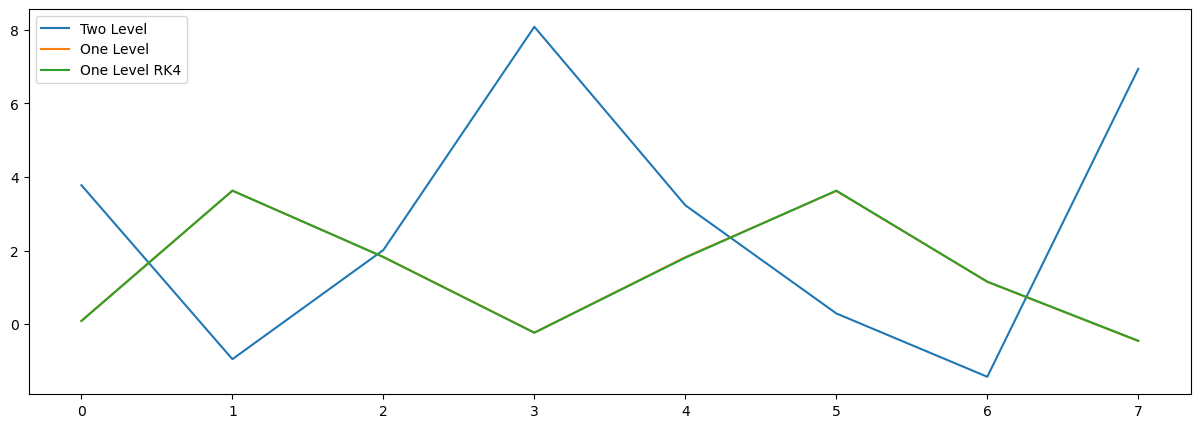

In [9]:
ts = 40
X1 = states_twolevel[ts,:K]
X2 = states_onelevel[ts,:]
XRK4 = states_onelevel_RK4[ts,:] 

fig = plt.figure(figsize=(15,5))
plt.plot(X1, label='Two Level')
plt.plot(X2, label='One Level')
plt.plot(XRK4, label='One Level RK4')
plt.legend()
plt.show()

### Polar Visualization

In [10]:
# coordinates
X_polar = [2*np.pi*i/K for i in range(K+1)]
Y_polar = [2*np.pi*i/(K*J) for i in range(K*J+1)]

### Visualize X in One- and Two-Level Systems 

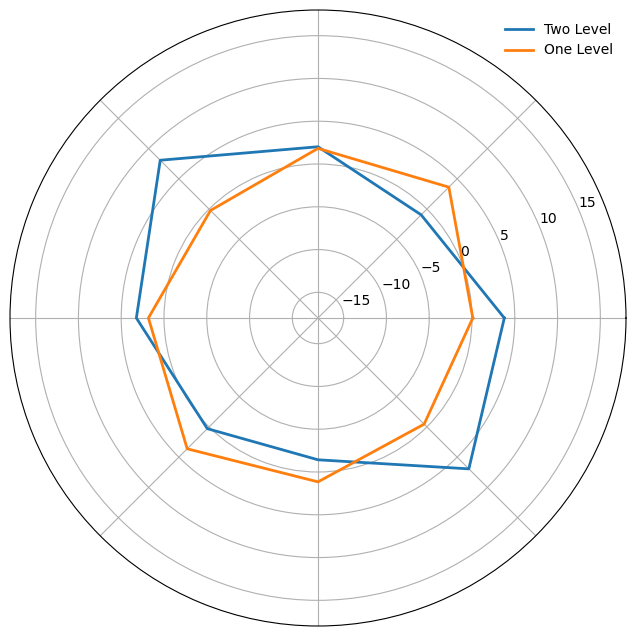

In [11]:
# Visualize X with and without small scales
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1, projection='polar')
ax.plot(X_polar, np.append(X1,X1[0]), lw=2, label='Two Level')
ax.plot(X_polar, np.append(X2,X2[0]), lw=2, label='One Level')
ax.set_rmin(-18); ax.set_rmax(18) # radius limits
ax.set_xticklabels([]) # remove theta ticks
#ax.set_yticklabels([]) # remove radius ticks
plt.legend(frameon=False, loc=1)
plt.show()

Slope: 0.05280856022228611
Intercept: -0.007883581875466728


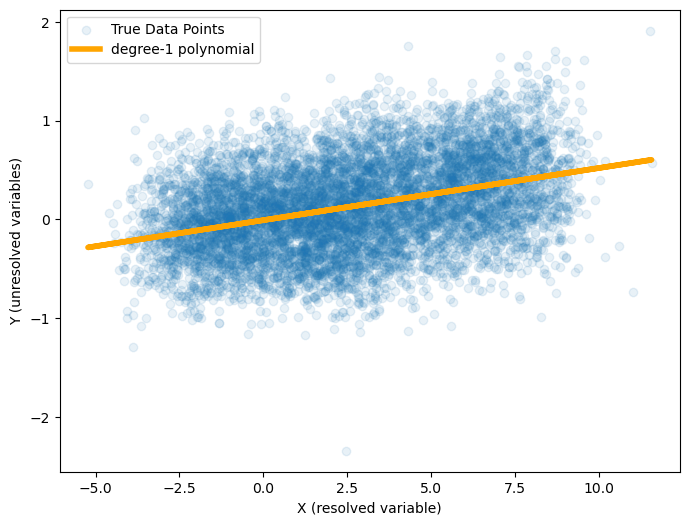

In [12]:
# degree 1 polynomial
slope, intercept = np.polyfit(states_twolevel[:8000,:K].ravel(), states_twolevel[:8000,K:2*K].ravel(), 1)
p_deg1 = np.poly1d([slope, intercept]) # create a 1d polynomial object
print('Slope:',slope)
print('Intercept:',intercept)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(states_twolevel[:1000,:K].ravel(), states_twolevel[:1000,K:2*K].ravel(), 
           alpha=0.1, label='True Data Points')
ax.plot(states_twolevel[:1000,:K].ravel(), p_deg1(states_twolevel[:1000,:K].ravel()),
        color='orange', lw=4, label='degree-1 polynomial')

plt.xlabel('X (resolved variable)'); plt.ylabel('Y (unresolved variables)')
ax.legend()
plt.show()

## Forecast

Set forecast time step = dt = training time step (this is required at this point during `training`. 
You can change it later in the RK4 integration during the forecast step.
A single model time unit (MTU), i.e., 1 MTU, is approx. equal to 5 `atmospheric days`

In [13]:
n_mtu = 1 # intended forecast period in terms of MTU  
dt_fcast = dt # forecast time step
nts_fcast = round(n_mtu/dt_fcast)  # number of forecast time steps
t_fcast = np.linspace(0,n_mtu,nts_fcast+1)

# h for RK4 integration
h_rk4 = 0.05 # This is the RK4 integration time step. Keep it small enough for convergence.
n_steps_rk4 = round(n_mtu/h_rk4)
print(f"Number of integrating time steps are: {n_steps_rk4}")

Number of integrating time steps are: 20


## Generate Catalogues

Here, following IG's idea, I have used the fact that the system is translation-invariant to increase the catalog size by a factor of `K`.

In [14]:
#catalogue0 = states_imperfect[:-nts_fcast,:] # initial condition
#catalogue1 = states_imperfect[nts_fcast:,:]  # final condition

tmp = t.shape[0]-nts_fcast
catalogue0_0 = np.zeros((K*tmp,K))
catalogue1_0 = np.zeros((K*tmp,K))
for i in range(K):
    catalogue0_0[tmp*i:tmp*(i+1),:] = np.roll(states_onelevel[:-nts_fcast,:],i,axis=1) # initial condition
    catalogue1_0[tmp*i:tmp*(i+1),:] = np.roll(states_onelevel[nts_fcast:,:],i,axis=1)  # final condition

print(catalogue0_0.shape)

(79928, 8)


## Include ICs away from the model attractors in the catalogs 

In [15]:
#catalogue0_1 = np.zeros((K*tmp,K))
#catalogue1_1 = np.zeros((K*tmp,K))
#stdev = 2
#for j in range(np.shape(catalogue0_0)[0]):
#    noise = np.random.normal(0,stdev,K)
#    ic = catalogue0_0[j,:] + noise
#    out = odeint(L96_onelevel,ic,t_fcast,args=args_onelevel)[-1,:]
#    # now add the ic and the corresponding forecast
#    catalogue0_1[j,:] = ic # IC
#    catalogue1_1[j,:] = out # Final state

In [16]:
#catalogue0_2 = np.zeros((K*tmp,K))
#catalogue1_2 = np.zeros((K*tmp,K))
#stdev = 3
#for j in range(np.shape(catalogue0_0)[0]):
#    noise = np.random.normal(0,stdev,K)
#    ic = catalogue0_0[j,:] + noise
#    out = odeint(L96_onelevel,ic,t_fcast,args=args_onelevel)[-1,:]
#    # now add the ic and the corresponding forecast
#    catalogue0_2[j,:] = ic # IC
#    catalogue1_2[j,:] = out # Final state

In [17]:
#catalogue0 = np.concatenate((catalogue0_0, catalogue0_1, catalogue0_2), axis=0)
#catalogue1 = np.concatenate((catalogue1_0, catalogue1_1, catalogue1_2), axis=0)
#catalogue0 = np.concatenate((catalogue0_0, catalogue0_2), axis=0)
#catalogue1 = np.concatenate((catalogue1_0, catalogue1_2), axis=0)
catalogue0 = catalogue0_0
catalogue1 = catalogue1_0

del catalogue0_0, catalogue1_0
#del catalogue0_1, catalogue1_1
#del catalogue0_2, catalogue1_2

gc.collect()

12519

## Study IC error as a function of number of nearest neighbors

N =  1
N =  2
N =  3
N =  4
N =  5
N =  6
N =  7
N =  8


/var/folders/_n/sx12xgq144db1d2t7cqj77140000gq/T/ipykernel_78683/3402854514.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reg_coeff = np.linalg.lstsq(A.T,state.T)[0]


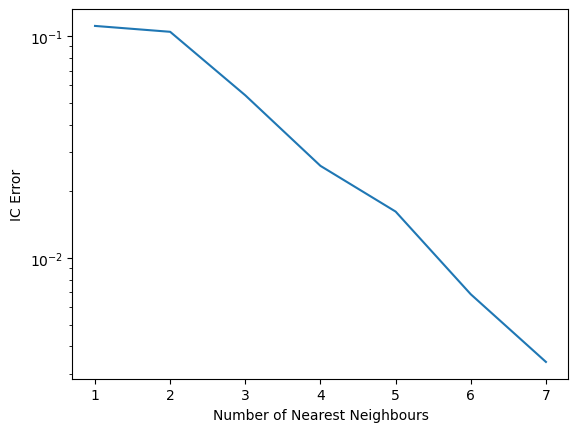

In [18]:
# generate a new state
#np.random.seed(101510)
cat0_mean = np.mean(catalogue0,axis=0)
cat0_std = np.std(catalogue0,axis=0)
state = np.random.randn(K) # generate a new state
state = state*(cat0_std) + cat0_mean
state = odeint(L96_onelevel,state,np.arange(0,10,0.1),args=args_onelevel)[-1,:]

# nearest neighbour numbers to test
nnn_min = 1; nnn_max = K; nnn_int = 1
nnn = np.arange(nnn_min,nnn_max+1,nnn_int).astype(int)

# compute the analogue for state for a given number of NN
state = np.reshape(state,[1,K])

# compute the distance between X_in and catalogue0
nn_dist = np.sqrt(np.mean((catalogue0 - state)**2, axis=1))
nn_indices = np.argsort(nn_dist)[:nnn_max]

# allocate for constructed analogs
analog_approx = np.zeros((nnn.shape[0],K))

for n in nnn:
    print('N = ', n)

    # get the nearest neighbours
    A = catalogue0[np.sort(nn_indices[:(n-nnn_min+1)]),:]
    
    # regression coefficients
    reg_coeff = np.linalg.lstsq(A.T,state.T)[0]
    
    # compute analogue and append to out_test
    analogue = A.T@reg_coeff
    analog_approx[n-nnn_min,:] = np.squeeze(analogue)

# compute the squared difference between analog approx and state
dist = np.sqrt(np.mean((analog_approx - state)**2, axis=1))

# plot distance vs number of nearest neighbours
fig = plt.figure()
plt.semilogy(nnn[:-1],dist[:-1])
plt.xlabel('Number of Nearest Neighbours')
plt.ylabel('IC Error')
plt.show()

1.5019029046975925
0.11449522635711294


(array([7.7850e+03, 9.4920e+03, 1.4133e+04, 1.3478e+04, 3.3611e+04,
        1.3760e+03, 1.8000e+01, 1.8000e+01, 9.0000e+00, 8.0000e+00]),
 array([0.11449523, 0.65608939, 1.19768356, 1.73927773, 2.2808719 ,
        2.82246607, 3.36406024, 3.90565441, 4.44724857, 4.98884274,
        5.53043691]),
 <BarContainer object of 10 artists>)

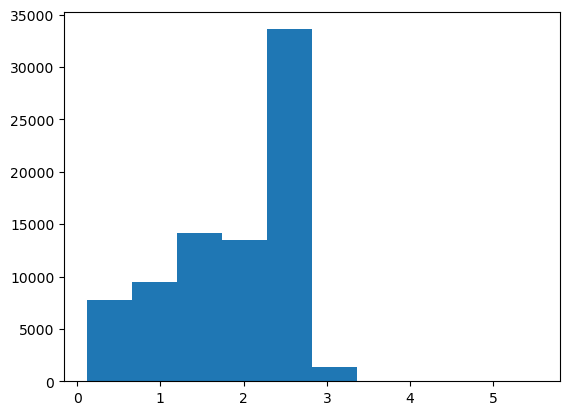

In [19]:
# The number below is the typical distance from a catalog member to the climatological mean. 
# With a catalog of ~360,000 members the nearest-neighbor distance is small compared to the distance to the mean: 
print(np.sqrt(np.mean((catalogue0-np.mean(catalogue0))**2)))
print(nn_dist[nn_indices[0]])
plt.hist(np.sort(nn_dist))

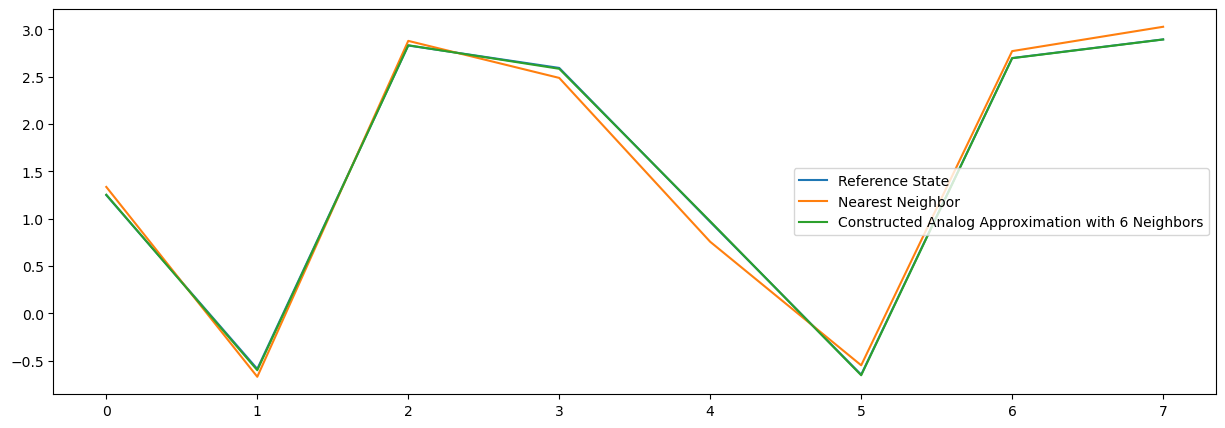

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(state[0,:])
plt.plot(catalogue0[nn_indices[0],:].T)
plt.plot(analog_approx[5,:])
plt.legend(['Reference State', 'Nearest Neighbor','Constructed Analog Approximation with 6 Neighbors'])
plt.show()

## CATs

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda
from tensorflow.keras.optimizers import RMSprop, SGD, Adagrad, Adadelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MinMaxScaler
from datetime import datetime

In [22]:
# Normalize the catalogues
normalization = 'standard' # values: standard/min-max

if normalization=='standard':
    scaler_cat0 = StandardScaler()
    scaler_cat0.fit(catalogue0)
    catalogue0_normal = scaler_cat0.transform(catalogue0)
    
    scaler_cat1 = StandardScaler()
    scaler_cat1.fit(catalogue1)
    catalogue1_normal = scaler_cat1.transform(catalogue1)

elif normalization=='min-max':
    scaler_cat0 = MinMaxScaler()
    scaler_cat0.fit(catalogue0)
    catalogue0_normal = scaler_cat0.transform(catalogue0)
    
    scaler_cat1 = MinMaxScaler()
    scaler_cat1.fit(catalogue1)
    catalogue1_normal = scaler_cat1.transform(catalogue1)

else:
    ValueError('Normalization type not recognised')

print(np.shape(catalogue0_normal),np.shape(catalogue1_normal))

(79928, 8) (79928, 8)


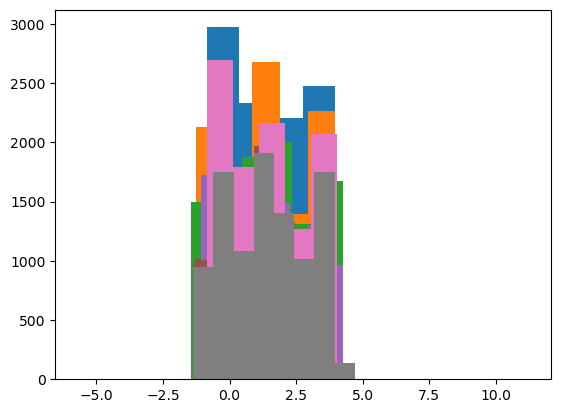

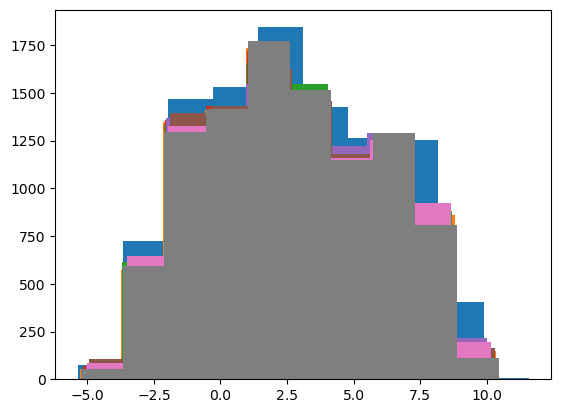

In [23]:
for k in range(K):
    plt.hist(states_onelevel[:,k])
plt.show()

for k in range(K):
    plt.hist(states_twolevel[:,k])
plt.show()

## CATs Implementation

In [24]:
# One-level function definition to use with tensors
@tf.function
def L96_onelevel_tf(y,F=10):
    dydt = -tf.roll(y,shift=-1,axis=-1)*(tf.roll(y,shift=-2,axis=-1) 
                                         - tf.roll(y,shift=1,axis=-1)) - y + F
    return dydt

# One-level parameterized function definition to use with tensors 
@tf.function
def L96_onelevel_param_tf(y,h=1,F=10,c=10):
    # Only linear X-Y relationship in this parameterized version
    py = slope*y+ intercept
    dydt = -tf.roll(y,shift=-1,axis=-1)*(tf.roll(y,shift=-2,axis=-1)
                                         -tf.roll(y,shift=1,axis=-1)) - y + F - h*c*py
    return dydt

@tf.function
def RK4_solve(tensor_obj):
    # tensor_obj has shape [None,K] and contains the initial conditions.
    # The L96_onelevel_tf function returns RHS of the L96 system of ODEs. 
    # The output also has the shape [None,K]
            
    args_param = {'h':h,'F':F_imp,'c':c}
    for n in tf.range(n_steps_rk4):
        k1 = L96_onelevel_param_tf(tensor_obj, **args_param)
        stage_2 = tf.math.add(tensor_obj, tf.math.multiply(h_rk4/2, k1))
        k2 = L96_onelevel_param_tf(stage_2, **args_param)
        stage_3 = tf.math.add(tensor_obj, tf.math.multiply(h_rk4/2, k2))
        k3 = L96_onelevel_param_tf(stage_3, **args_param)
        stage_4 = tf.math.add(tensor_obj, tf.math.multiply(h_rk4, k3))
        k4 = L96_onelevel_param_tf(stage_4, **args_param)
        update =  tf.math.add(tf.math.add(tf.math.add(k1,2*k2),2*k3),k4)
        tensor_obj = tf.math.add(tensor_obj, tf.math.multiply(h_rk4/6,update))           
                
    return tensor_obj
            
# custom layer with custom gradient
@tf.custom_gradient
def model_output(X_in): # (None, K)
    #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
    #+-+-+-+-+- Inverse Transform X_in +-+-+-+-+-+- 
    #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
    if normalization == 'min-max'.lower():
        max_tensor = tf.expand_dims(tf.convert_to_tensor(scaler_cat0.data_max_, dtype=tf.float32), axis=0)  # (1,K)
        min_tensor = tf.expand_dims(tf.convert_to_tensor(scaler_cat0.data_min_, dtype=tf.float32), axis=0)  # (1,K)
        out1 = tf.math.multiply(X_in, tf.math.subtract(max_tensor, min_tensor))             # (None, K)
        out1 = tf.math.add(out1, min_tensor)                                                # (None, K)
        
    elif normalization == 'standard'.lower():
        mean_tensor = tf.expand_dims(tf.convert_to_tensor(scaler_cat0.mean_, dtype=tf.float32), axis=0)    # (1,K)
        std_tensor = tf.expand_dims(tf.convert_to_tensor(np.sqrt(scaler_cat0.var_), dtype=tf.float32), axis=0)  # (1,K)
        out1 = tf.math.multiply(X_in, std_tensor)                                # (None,K)
        out1 = tf.math.add(out1, mean_tensor)                                    # (None,K)
    
    else:
        raise ValueError('Normalization type not recognised')
    
    #out1 = out1[:,:K]                 # (None, K)
    print('Out1 shape:', out1.shape)
    
    #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
    #+- Time integration using the imperfect model +- 
    #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
    
    out2 = RK4_solve(out1)
    print('Shape of out2:', out2.shape) 
    
    #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
    #+-+-+-+-+- Forward Transform out2 +-+-+-+-+-+-+- 
    #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
    
    # Now transform it back
    if normalization == 'min-max'.lower():
        max_tensor = tf.expand_dims(tf.convert_to_tensor(scaler_cat1.data_max_, dtype=tf.float32), axis=0)  # (1,K)
        min_tensor = tf.expand_dims(tf.convert_to_tensor(scaler_cat1.data_min_, dtype=tf.float32), axis=0)  # (1,K)
        out3 = tf.math.divide(tf.math.subtract(out2, min_tensor), tf.math.subtract(max_tensor, min_tensor))  # (None, K)
    
    elif normalization == 'standard'.lower():
        mean_tensor = tf.expand_dims(tf.convert_to_tensor(scaler_cat1.mean_, dtype=tf.float32), axis=0)  # (1,K)
        std_tensor = tf.expand_dims(tf.convert_to_tensor(np.sqrt(scaler_cat1.var_), dtype=tf.float32), axis=0)  # (1,K)
        out3 = tf.math.divide(tf.math.subtract(out2, mean_tensor), std_tensor)   # (None,K)
    
    print('Shape of out3:', out3.shape) 
    
    # compute gradient
    def model_grad(upstream):
        ## perform forward computation ##
        # number of nearest neighbours
        nnn = 5
    
        # convert catalogue0 and catalogue1 to tensors
        #cat0_tensor = tf.convert_to_tensor(catalogue0_normal, dtype=tf.float32)  # (catsize,36)
        #cat1_tensor = tf.convert_to_tensor(catalogue1_normal, dtype=tf.float32)  # (catsize,36)
        cat0_tensor = tf.convert_to_tensor(catalogue0, dtype=tf.float32)  # (catsize,36)
        cat1_tensor = tf.convert_to_tensor(catalogue1, dtype=tf.float32)  # (catsize,36)
        
        # compute the distance between X_in and catalogue0
        #X_in_expand = tf.expand_dims(X_in,axis=1)  # (None,1,K)
        X_in_expand = tf.expand_dims(out1,axis=1)  # (None,1,K)
        
        temp = tf.math.subtract(X_in_expand,cat0_tensor)    # (None,catsize,36)
        temp_sq = tf.math.square(temp)                      # (None,catsize,36)
        dist = tf.math.sqrt(tf.math.reduce_mean(temp_sq, axis=2))    # (None,catsize)
    
        # get the nearest neighbours
        sort_order = tf.argsort(dist,axis=1)[:,:nnn]        # (None,nnn)
    
        A = tf.gather(cat0_tensor, sort_order, axis=0)    # (None,nnn,36)
        B = tf.gather(cat1_tensor, sort_order, axis=0)    # (None,nnn,36)
        
        # regression coefficient for the initial condition x_in
        epsilon = tf.constant(1e-3) # Tikhonov Regularization amplitude (for collinearity issue)
        AA_T = tf.linalg.matmul(A,tf.transpose(A, perm=[0,2,1])) + epsilon*tf.eye(num_rows=nnn, num_columns=nnn) # (None,nnn,nnn)
        
        temp = tf.linalg.solve(AA_T,A) # (None,nnn,3)
        grad_local = tf.linalg.matmul(tf.transpose(B,perm=[0,2,1]),temp) # (None,3,3)
        grad = tf.squeeze(tf.expand_dims(upstream,axis=1)@grad_local,axis=1)
        return grad
    
    return out3, model_grad

class ModelLayer(tf.keras.layers.Layer): # inherited from keras layers.Layer class
    def __init__(self,units,**kwargs):
        super(ModelLayer,self).__init__(**kwargs) 
        self.units = units
        #self.total = tf.Variable(initial_value=tf.zeros((input_dim,)), trainable=False)
    
    def build(self, input_shape): 
        self.kernel = self.add_weight(name = 'kernel',shape = (input_shape[-1], self.units), 
                                     initializer = 'identity', trainable = False)
        super(ModelLayer, self).build(input_shape)
    
    def call(self,inputs):
        #batch_size = tf.shape(inputs)[0]
        #self.batch_size = batch_size
        return model_output(inputs@self.kernel)
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],self.units)
    
# custom loss funtion
def custom_loss_mae(y_truth, y_pred):
    # based on MAE (less sensitive to the outliers)
    loss = tf.math.reduce_mean(tf.math.abs(y_pred[:,:K]-y_truth[:,:K]), axis=-1)
    return loss

def custom_loss_mse(y_truth, y_pred):
    # based on mse (more sensitive to outliers)
    loss = tf.math.reduce_mean(tf.math.square(y_pred[:,:K]-y_truth[:,:K]), axis=-1)
    return loss

In [26]:
#+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
#+-+-+-+-+-+-+-+-+-+-+- CATs +-+-+-+-+-+-+-+-+-+-+-+-+
#+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
class CATS(tf.keras.Model):
    
    # constructor
    def __init__(self, nvar_ref, nvar_model, J, isreg=False, lmbda=0.01, 
                 act_fn='linear', isbias=False, alpha=1, beta=0, 
                 initializer=tf.keras.initializers.GlorotUniform(),**kwargs):
        
        super(CATS, self).__init__(**kwargs)

        # input layer
        inputs1 = tf.keras.Input(shape=(nvar_ref,))
    
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        #+-+ Real to Model space tranformation -- T_rm +-+
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
   
        if isreg:
            h1_rm = Dense(10, activation=act_fn, use_bias=isbias, kernel_regularizer=
                          tf.keras.regularizers.L2(l2=lmbda),kernel_initializer=initializer)(inputs1)
            #h2_rm = Dense(100, activation=act_fn, use_bias=isbias,kernel_regularizer=
            #              tf.keras.regularizers.L2(l2=lmbda),kernel_initializer=initializer)(h1_rm)
            #h3_rm = Dense(100, activation=act_fn, use_bias=isbias,kernel_regularizer=
            #              tf.keras.regularizers.L2(l2=lmbda),kernel_initializer=initializer)(h2_rm)
            #h4_rm = Dense(100, activation=act_fn, use_bias=isbias,kernel_regularizer=
            #              tf.keras.regularizers.L2(l2=lmbda),kernel_initializer=initializer)(h3_rm)
            out_rm = Dense(nvar_model, activation=act_fn, use_bias=isbias,kernel_regularizer=
                           tf.keras.regularizers.L2(l2=lmbda),kernel_initializer=initializer)(h1_rm)
            
        else:
            h1_rm = Dense(10, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(inputs1) 
            #h2_rm = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h1_rm)
            #h3_rm = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h2_rm)
            #h4_rm = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h3_rm)
            out_rm = Dense(nvar_model, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h1_rm)
            
        # This adds the linear component
        outputs_trm = tf.keras.layers.Add()([inputs1[:,:nvar_model], out_rm])
        
        T_rm = tf.keras.Model(inputs=inputs1, outputs=outputs_trm)
        
        print(T_rm.summary())
        
        # store T_rm as a property of cats
        self.T_rm = T_rm
        
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        #+-+ Set the custom layer as a one layer model +-+
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        
        # Input layer
        inputs2 = tf.keras.Input(shape=(nvar_model,))
        
        # Output layer
        outputs_custom = ModelLayer(nvar_model, input_shape=(nvar_model,))(inputs2)
        
        # Define the analog forecast model
        model_fcast = tf.keras.Model(inputs=inputs2, outputs=outputs_custom)
        
        print(model_fcast.summary())
        
        # store analog_fcast as a property of gmaps 
        self.model_fcast = model_fcast
        
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        #+-+ Model to Real space tranformation -- T_mr +-+
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        
        # Input layer
        inputs3 = tf.keras.Input(shape=(nvar_model,))
        
        if isreg:
            h1_mr = Dense(10, activation=act_fn, use_bias=isbias, kernel_initializer=initializer,
                          kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda))(inputs3)
            #h2_mr = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer,
            #              kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda))(h1_mr)
            #h3_mr = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer,
            #              kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda))(h2_mr)
            #h4_mr = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer,
            #              kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda))(h3_mr)
            out_mr = Dense(nvar_ref, activation=act_fn, use_bias=isbias, kernel_initializer=initializer,
                           kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda))(h1_mr)
        else:
            h1_mr = Dense(10, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(inputs3)
            #h2_mr = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h1_mr)
            #h3_mr = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h2_mr)
            #h4_mr = Dense(100, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h3_mr)
            out_mr = Dense(nvar_ref, activation=act_fn, use_bias=isbias, kernel_initializer=initializer)(h1_mr)
    
        # compute the linear part of the forecast
        alpha_t = tf.constant(alpha, dtype=tf.float32)
        beta_t = tf.constant(beta, dtype=tf.float32) # alpha/beta tensors
        linear_approx_ss = alpha_t*(inputs3) + beta_t     #(None, nvar_model)
        linear_approx_ss_J = tf.tile(linear_approx_ss, [1, J]) # (None, J*nvar_model)
        linear_part = tf.concat([inputs3, linear_approx_ss_J],-1)
        print('Linear part shape:',linear_part.shape)
    
        # final output of the model
        outputs_tmr = tf.keras.layers.Add()([linear_part,out_mr])
        
        T_mr = tf.keras.Model(inputs=inputs3,outputs=outputs_tmr)
        
        print(T_mr.summary())
        
        # store T_mr as a property of gmaps 
        self.T_mr = T_mr
        
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        #+-+-+-+-+-+- setup the full model +-+-+-+-+-+-+-+
        #+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
        cat = tf.keras.Model(inputs=inputs1, outputs=T_mr(model_fcast(T_rm(inputs1))))
        self.cat = cat
        
    def train(self, x, y, loss='mae', optimizer='adam',metric='mae',epochs=100, 
              validation_split=0.2, batch_size=512):         
            
        # Configuring the learning process
        self.cat.compile(loss=loss, optimizer=optimizer, metrics=[metric])
            
        # This is the training part of the network:
        history = self.cat.fit(x, y, epochs=epochs, validation_split=validation_split,
                               batch_size=batch_size)
        
        return self.cat, history
        
    # Save weights
    def save_weights(self, path, case, **kwargs,):
        self.T_rm.save_weights(path+'L96_trm.h5')
        self.model_fcast.save_weights(path+'L96_analog_fcast.h5')
        self.T_mr.save_weights(path+'L96_tmr.h5')
        
    # Load weights
    def load_weights(self, path, case, **kwargs):
        self.T_rm.load_weights(path+'L96_trm.h5',by_name=True)
        self.model_fcast.load_weights(path+'L96_analog_fcast.h5',by_name=True)
        self.T_mr.load_weights(path+'L96_tmr.h5',by_name=True)

    # Countparams
    def count_params(self, **kwargs):
        return self.T_rm.count_params() + self.model_fcast.count_params() + self.T_mr.count_params()
    
    # Predict
    def r2m(self, data):
        return self.T_rm(data)
        
    def m2r(self, data):
        return self.T_mr(data)
    
    def custom_layer(self, data):
        return self.model_fcast(data)
        
    def forecast(self,data,batch_size=1):
        out1 = self.T_rm.predict(data,batch_size=batch_size)
        out2 = self.model_fcast.predict(out1,batch_size=batch_size)
        out3 = self.T_mr.predict(out2,batch_size=batch_size)
        return out3

### CATs parameter optimization

In [29]:
# Train the Neural Network
start = datetime.now()
lmbda = 1/80
isreg = False
 
# CATS definition parameters
def_params = {'isreg':False, 'lmbda':lmbda**2, 
              'act_fn':'tanh', 'isbias':True,
              #'alpha':0, 'beta':0}
              'alpha':slope, 'beta':intercept}

# CATS training hyperparameters
hyperparams = {'loss':custom_loss_mae, 
    'optimizer':'adam','metric':'mae',
    'epochs':50,'validation_split':0.2,
    'batch_size':512,}

# standardize the training data
if normalization=='standard':
    scaler = StandardScaler()
    scaler.fit(states_twolevel)
    train_data = scaler.transform(states_twolevel)

elif normalization=='min-max':
    scaler = MinMaxScaler()
    scaler.fit(states_twolevel)
    train_data = scaler.transform(states_twolevel)

else:
    ValueError('Normalization type not recognised')

x_train = train_data[:-nts_fcast,:]
y_train = train_data[nts_fcast:,:]

# Create a CATS object
cat_l96 = CATS(K*J+K, K, J, **def_params)

model, history = cat_l96.train(x_train,y_train,**hyperparams)

print('Training time:',datetime.now()-start)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 10)           410         ['input_7[0][0]']                
                                                                                                  
 tf.__operators__.getitem_2 (Sl  (None, 8)           0           ['input_7[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 dense_9 (Dense)                (None, 8)            88          ['dense_8[0][0]']          

Epoch 21/50
16/16 [==============================] - 10s 613ms/step - loss: 0.5152 - mae: 0.7952 - val_loss: 0.5136 - val_mae: 0.7967
Epoch 22/50
16/16 [==============================] - 9s 587ms/step - loss: 0.5124 - mae: 0.7946 - val_loss: 0.5108 - val_mae: 0.7960
Epoch 23/50
16/16 [==============================] - 9s 581ms/step - loss: 0.5100 - mae: 0.7940 - val_loss: 0.5082 - val_mae: 0.7954
Epoch 24/50
16/16 [==============================] - 9s 585ms/step - loss: 0.5078 - mae: 0.7934 - val_loss: 0.5059 - val_mae: 0.7947
Epoch 25/50
16/16 [==============================] - 9s 588ms/step - loss: 0.5057 - mae: 0.7929 - val_loss: 0.5035 - val_mae: 0.7943
Epoch 26/50
16/16 [==============================] - 9s 591ms/step - loss: 0.5038 - mae: 0.7924 - val_loss: 0.5016 - val_mae: 0.7938
Epoch 27/50
16/16 [==============================] - 9s 592ms/step - loss: 0.5020 - mae: 0.7920 - val_loss: 0.4997 - val_mae: 0.7934
Epoch 28/50
16/16 [==============================] - 9s 588ms/step -

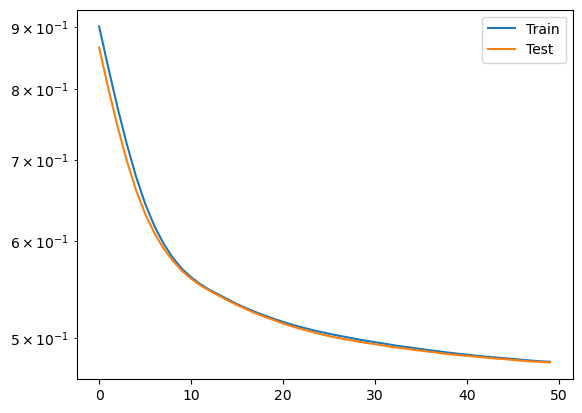

In [30]:
%matplotlib inline
# plot history
plt.semilogy(history.history['loss'], label='Train')
plt.semilogy(history.history['val_loss'], label='Test')
plt.legend()
#plt.savefig(f'Training_loss_function_testData_nmtu-{n_mtu}_K-{K}_J-{J}_4-layer_100neurons_{normalization}_maeloss_nearZeroInitializer_regularized_lambda-{lmbda}_noAnalog.jpeg',dpi=300)
plt.show()

### Trying to interpret weight matrices

In [34]:
wg = cat_l96.T_rm.get_weights()
print(np.shape(wg[0]))
print(np.shape(wg[1]))

(40, 10)
(10,)


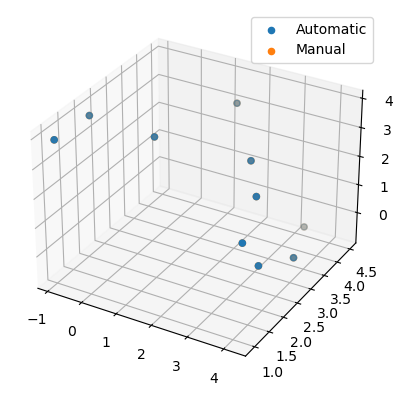

In [42]:
nic = 10
ics = scaler.transform(states_twolevel[:nic,:])
fcs_nn = scaler_cat0.inverse_transform(cat_l96.r2m(ics))

# Manual computation
temp = np.tanh(ics@wg[0]+ np.tile(wg[1].reshape(1,-1),[nic,1]))
temp2 = np.tanh(temp@wg[2] + np.tile(wg[3].reshape(1,-1),[nic,1]) )
fcs_man = scaler_cat0.inverse_transform(ics[:,:K]+temp2)

# plot
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection="3d"))
ax.scatter(fcs_nn[:,0],fcs_nn[:,1],fcs_nn[:,2],label='Automatic')
ax.scatter(fcs_man[:,0],fcs_man[:,1],fcs_man[:,2],label='Manual')
plt.legend()
plt.show()

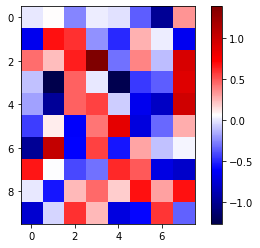

In [30]:
plt.imshow(wg[2], cmap='seismic')
plt.colorbar()
plt.show()

In [31]:
np.shape(wg[1].reshape(1,-1))

(1, 10)

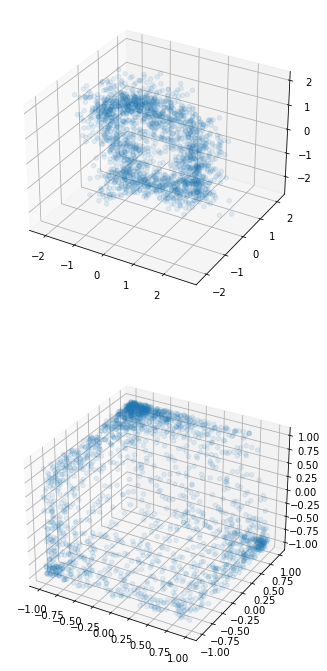

In [32]:
# Try to visualize the space spanned by NN 
wg_rm = cat_l96.T_rm.get_weights()
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(2,1,1,projection='3d')

ax.scatter(x_train[:2000,0],x_train[:2000,1],x_train[:2000,2],alpha=0.1)

ax = fig.add_subplot(2,1,2,projection='3d')
state_hidden_nn = np.tanh(x_train[:2000,:]@wg_rm[0] + np.tile(wg_rm[1].reshape(1,-1),[2000,1]) )
ax.scatter(state_hidden_nn[:2000,0],state_hidden_nn[:2000,8],state_hidden_nn[:2000,9],alpha=0.1)
plt.show()

### Get CATs Outcome for the test dataset

In [33]:
# check the truth vs the mapped outcomes
#n_check = 100
#n_check = np.shape(x_train)[0]
n_tot = np.shape(x_train)[0]
n_train = round(n_tot*0.8) # change 0.8 to whatever training vs test ratio used in the training
n_test = n_tot-n_train  
states_ANN = np.zeros((n_test,K*J+K)) # output using the imperfect model

for k in range(n_test):
    states_ANN[k,:] = cat_l96.forecast(np.reshape(x_train[n_train+k,:], [1,-1]), batch_size=1)
    
states_ANN_scaled = scaler.inverse_transform(states_ANN)

Out1 shape: (1, 8)
Shape of out2: (1, 8)
Shape of out3: (1, 8)


### Compute Residuals and Error Statistics

In [34]:
#residual = states_twolevel[nts_fcast:n_check+nts_fcast,:] - states_ANN_scaled
residual = states_twolevel[nts_fcast+n_train:n_train+nts_fcast+n_test,:] - states_ANN_scaled
print('Residual Mean using analog forecasting: \n', np.mean(residual, axis=0))
print('Residual std using analog forecasting: \n', np.std(residual, axis=0))

Residual Mean using analog forecasting: 
 [-0.26084124 -0.01479308 -0.11745206  0.23241062 -0.14772979 -0.16400101
 -0.03662649  0.06333874  0.09441647  0.11101433  0.00469018 -0.06070663
  0.0515672   0.11568491 -0.0146384  -0.03684633  0.11304683  0.09903825
  0.05737166 -0.00162601 -0.08581731 -0.09921913 -0.01910323  0.10060137
 -0.02444817  0.10370535 -0.05402834 -0.00371566 -0.06546405 -0.01939569
 -0.10163893  0.04146458 -0.08233476  0.01882364  0.00809413  0.05583081
 -0.0218556   0.0603582   0.0375648   0.01080159]
Residual std using analog forecasting: 
 [1.95152942 1.92391193 1.88398362 1.87520121 1.86838559 1.96245354
 2.00550807 1.97666714 0.48266239 0.47176912 0.49462611 0.49506372
 0.50809984 0.55465949 0.51069938 0.46224338 0.47165629 0.4855776
 0.45878908 0.525259   0.44309529 0.46350041 0.46784032 0.44455199
 0.49523556 0.46589804 0.49418485 0.4635046  0.44709015 0.49356313
 0.45767963 0.51852549 0.47106294 0.45652453 0.45271415 0.45491024
 0.43929122 0.45581275 0.442

### Visualize the CATs outputs vs Truth

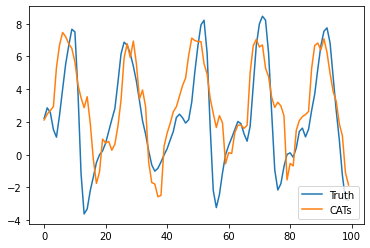

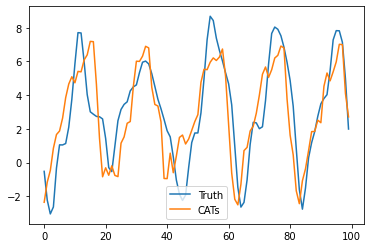

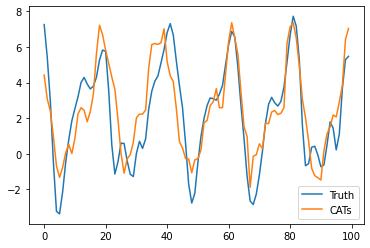

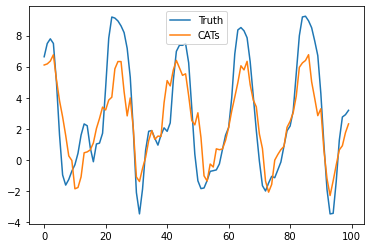

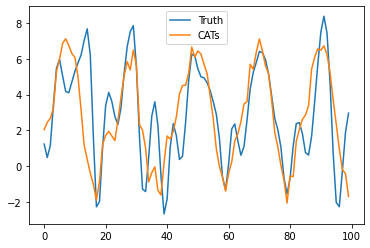

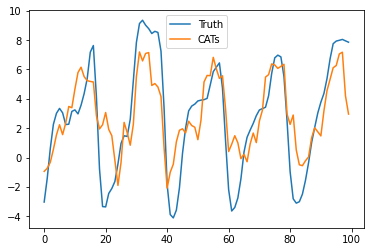

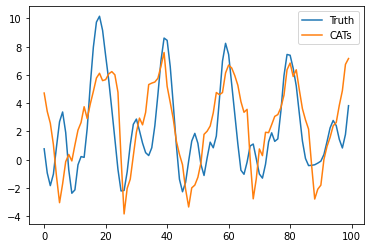

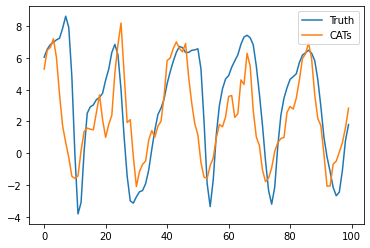

In [35]:
%matplotlib inline
for k in range(K):
    plt.plot(states_twolevel[n_train+nts_fcast:100+n_train+nts_fcast,k], label='Truth') # Truth
    plt.plot(states_ANN_scaled[:100,k], label='CATs') # ANN output
    #plt.plot(states_imperfect[nts_fcast:n_check+nts_fcast,k], label='Imperfect')
    plt.legend(loc='best')
    plt.show()

## CATs RMSE

In [36]:
print('CATs RMSE:',np.sqrt(np.nanmean(residual[:,:K]**2, axis=(0,1))))

CATs RMSE: 1.9376913653870664


## Bootstrapping to compute 95% confidence intervals 

In [133]:
# draw bootstrap sample from a 1D dataset
def draw_random_samples(data):
    return np.random.choice(data, size=len(data))

# perform pair bootstrpping
def bootstrap(x, size=10000):
    out = np.empty(size)
    for i in range(size):
        indices = np.arange(np.shape(x)[0])
        bs_indices = draw_random_samples(indices)
        resampled_dat = x[bs_indices,:K]
        out[i] = np.sqrt(np.nanmean(resampled_dat**2, axis=(0,1)))
    return out

In [134]:
rmse_bs = bootstrap(residual)

## Confidence Interval Plot 

In [139]:
# Plot Confidence Interval
def confidence_interval(x, data, ax, hline_width = 25, 
                        color='#2187bb', label='label'):
    left = x - hline_width/2
    right = x + hline_width/2
    
    # median
    med = np.median(data)
    
    # 95% confidence interval
    alpha = 0.025
    data = np.sort(data)
    idx = int(len(data)*alpha) # bottom index
    bottom = data[idx]
    idx = int(len(data)*(1-alpha)) # top index
    top = data[idx]
    
    # plot
    ax.plot([x, x], [top, bottom], '--', linewidth=2, color=color, label=label)
    ax.plot([left, right], [top, top], '--', linewidth=2, color=color)
    ax.plot([left, right], [bottom, bottom], '--', linewidth=2, color=color)
    ax.plot(x, med, 'o', color=color)
        
    return

<IPython.core.display.Javascript object>


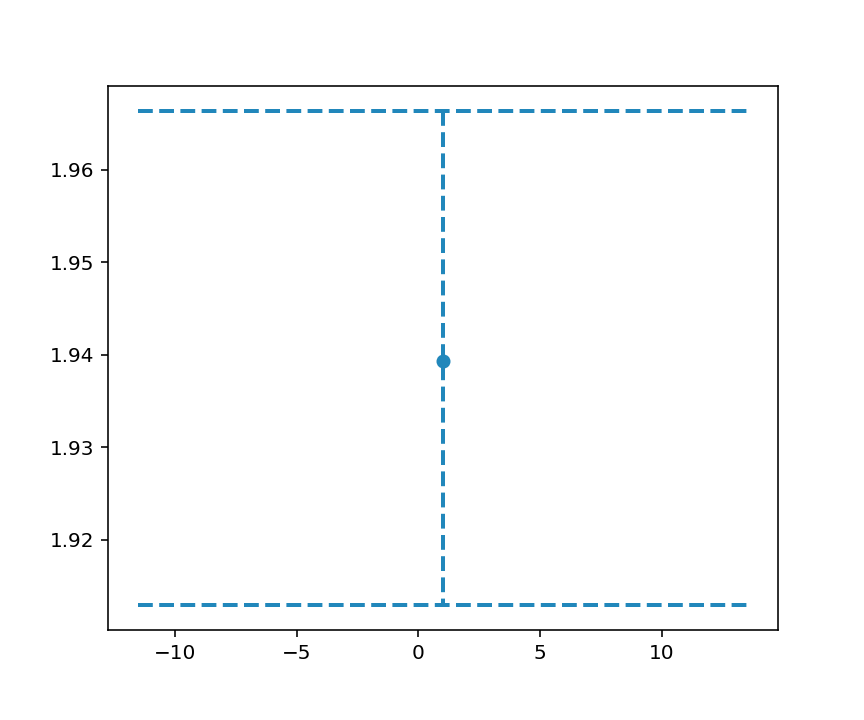

In [140]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)
confidence_interval(1,rmse_bs,ax,label='Nonlinear CATs')

## Climatology forecast RMSE

In [34]:
print('Climatology Forecast RMSE:', np.sqrt(np.mean((states_twolevel[n_train:,:K]-np.mean(states_twolevel[:,:K]))**2)))

Climatology Forecast RMSE: 3.2484819571774075


## Persistence Forecast in the perfect model space

In [35]:
rmse_persist_perfect_model = np.sqrt(np.mean((states_twolevel[n_train+nts_fcast:n_train+nts_fcast+n_test,:K]-
                                              states_twolevel[n_train:n_train+n_test,:K])**2))
print('Persistence Forecast RMSE:', rmse_persist_perfect_model)

Persistence Forecast RMSE: 5.806971080301076


In [36]:
for nts_forward in range(1,21):
    n_tot = 10000-nts_forward
    n_train = round(n_tot*0.8) # change 0.8 to whatever training vs test ratio used in the training
    n_test = n_tot-n_train  
    rmse_persist_perfect_model = np.sqrt(np.mean((states_twolevel[n_train+nts_forward:n_train+nts_forward+n_test,:K]-
                                         states_twolevel[n_train:n_train+n_test,:K])**2))
    print('Forecast lead time:',nts_forward*dt_fcast,
          '\n Perfect Model Persistence RMSE:',rmse_persist_perfect_model)

Forecast lead time: 0.1 
 Perfect Model Persistence RMSE: 1.4070678022360286
Forecast lead time: 0.2 
 Perfect Model Persistence RMSE: 2.6341670867973677
Forecast lead time: 0.30000000000000004 
 Perfect Model Persistence RMSE: 3.5976580226740995
Forecast lead time: 0.4 
 Perfect Model Persistence RMSE: 4.304223876178286
Forecast lead time: 0.5 
 Perfect Model Persistence RMSE: 4.8088961477844965
Forecast lead time: 0.6000000000000001 
 Perfect Model Persistence RMSE: 5.170435770787631
Forecast lead time: 0.7000000000000001 
 Perfect Model Persistence RMSE: 5.431895710747038
Forecast lead time: 0.8 
 Perfect Model Persistence RMSE: 5.619249521715361
Forecast lead time: 0.9 
 Perfect Model Persistence RMSE: 5.744183264962418
Forecast lead time: 1.0 
 Perfect Model Persistence RMSE: 5.807006575544456
Forecast lead time: 1.1 
 Perfect Model Persistence RMSE: 5.798818318079012
Forecast lead time: 1.2000000000000002 
 Perfect Model Persistence RMSE: 5.702931541519733
Forecast lead time: 1.3

## Random State Forecast RMSE

In [38]:
#dist = []
#for i in range(50):
#    for j in range(np.shape(states_twolevel[:,])[0]):
#        err = np.sqrt(np.mean((states_twolevel[i,:K] - states_twolevel[j,:K])**2))
#        dist.append(err)
#    
#print('Random State Forecast Error:', np.mean(dist))

## Zero CATs weight forecast RMSE

In [37]:
# CATS definition parameters
def_params = {'isreg':False, 'lmbda':lmbda**2, 
              'act_fn':'tanh', 'isbias':True,
              'initializer':tf.keras.initializers.zeros(),
              'alpha':slope, 'beta':intercept}

# CATS training hyperparameters
hyperparams = {'loss':custom_loss_mae, 
    'optimizer':'adam','metric':'mae',
    'epochs':0,'validation_split':0.2,
    'batch_size':512,}

# Create a CATS object
cat_l96_zeroweight = CATS(K*J+K, K, J, **def_params)
model, history = cat_l96_zeroweight.train(x_train,y_train,**hyperparams)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 10)           410         ['input_4[0][0]']                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 8)           0           ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 dense_5 (Dense)                (None, 8)            88          ['dense_4[0][0]']          

In [38]:
# Get the zero-weight CATs output
states_zeroweight = np.zeros((n_test,K*J+K)) # output
for k in range(n_test):
    states_zeroweight[k,:] = cat_l96_zeroweight.forecast(np.reshape(x_train[n_train+k,:], [1,-1]), batch_size=1)
    
# Scale the zero weight outputs
states_zeroweight = scaler.inverse_transform(states_zeroweight)

# Compute RMSE
residual_zeroweight = states_twolevel[n_train+nts_fcast:n_train+n_test+nts_fcast,:] - states_zeroweight
print('Zero CATs Weight output Error:',np.sqrt(np.nanmean(residual_zeroweight[:,:K]**2, axis=(0,1))))

Out1 shape: (1, 8)
Shape of out2: (1, 8)
Shape of out3: (1, 8)
Zero CATs Weight output Error: 3.923887285838579


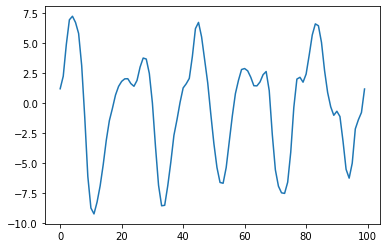

In [39]:
plt.plot(residual_zeroweight[900:1000,0])
plt.show()

In [40]:
# Sanity Check of zero weight CATs
print('Input:',x_train[0,:K])
out_Trm = cat_l96_zeroweight.r2m(x_train[0,:].reshape(1,-1))
print('Out Trm:',out_Trm)
out_custom=cat_l96_zeroweight.custom_layer(np.reshape(out_Trm, (1,-1)))
print('Custom Layer output:',out_custom)
out_Tmr = cat_l96_zeroweight.m2r(np.reshape(out_custom, (1,-1)))
print('CATs Zero Weight:', out_Tmr[:,:K+J])

Input: [ 1.95684348  1.05081204 -2.42995174 -0.05076494  0.89648129 -1.16667046
  0.33980173  0.11200643]
Out Trm: tf.Tensor(
[[ 1.9568435   1.050812   -2.4299517  -0.05076494  0.8964813  -1.1666704
   0.33980173  0.11200643]], shape=(1, 8), dtype=float32)
Out1 shape: (1, 8)
Shape of out2: (1, 8)
Shape of out3: (1, 8)
Custom Layer output: tf.Tensor(
[[ 1.0278704   0.5856149  -0.26541114 -0.74831146  0.19558796  0.49521756
  -0.24045017 -0.7676968 ]], shape=(1, 8), dtype=float32)
CATs Zero Weight: tf.Tensor(
[[ 1.0278704   0.5856149  -0.26541114 -0.74831146  0.19558796  0.49521756
  -0.24045017 -0.7676968   0.04639677  0.0230419  -0.02189956 -0.04740083]], shape=(1, 12), dtype=float32)


<IPython.core.display.Javascript object>


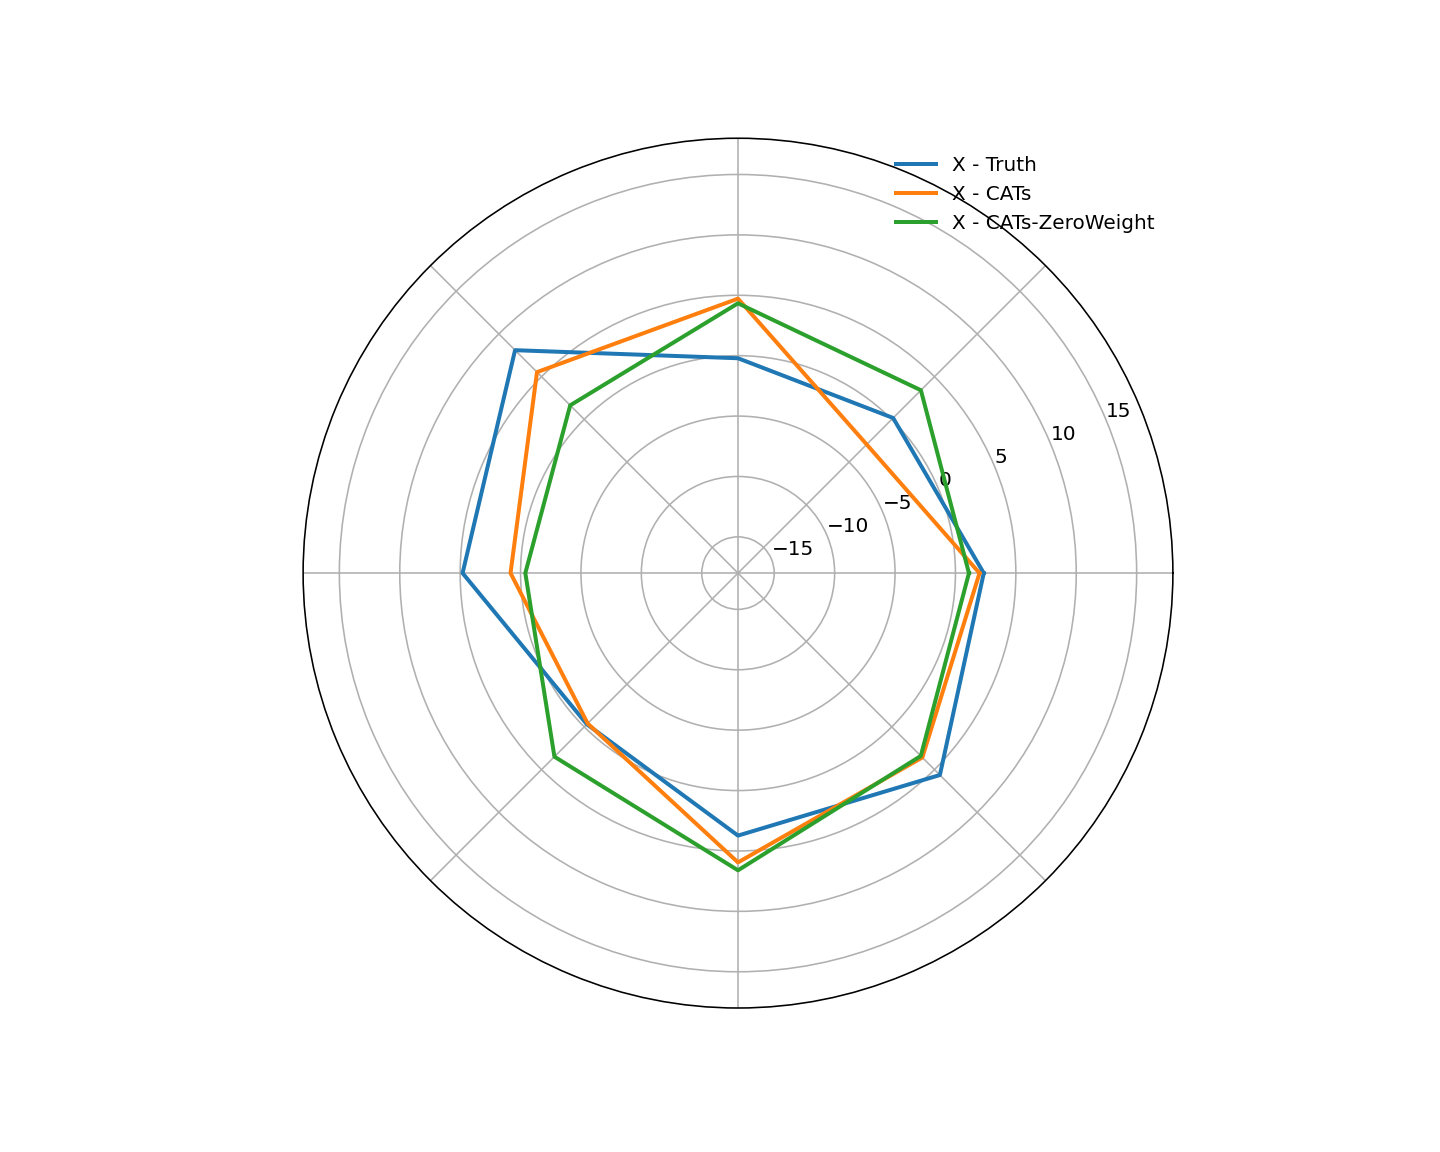

In [40]:
# Truth vs CATs vs Zero Weight CATs
#fig = plt.figure(figsize=(21,8))
ts = 900 # time step to plot
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(1,1,1, projection='polar')

# Truth
ax.plot(X_polar, np.append(states_twolevel[n_train+ts+nts_fcast,:K],states_twolevel[n_train+ts+nts_fcast,0]), 
        lw=2, label='X - Truth') 
# CATs
ax.plot(X_polar, np.append(states_ANN_scaled[ts,:K],states_ANN_scaled[ts,0]), lw=2, 
        label='X - CATs')
# CATs zero weight
ax.plot(X_polar, np.append(states_zeroweight[ts,:K],states_zeroweight[ts,0]), lw=2, 
        label='X - CATs-ZeroWeight')
ax.set_rmin(-18); ax.set_rmax(18) # radius limits
ax.set_xticklabels([]) # remove theta ticks
#ax.set_yticklabels([]) # remove radius ticks
ax.legend(frameon=False, loc=1)

#------------------------------------------
# CATs vs Imperfect -- Analogs
#ax[1].plot(X_polar, np.append(states_ANN_scaled[ts,:K],states_ANN_scaled[ts,0]), lw=2, 
#        label='X - CATs')
#ax[1].plot(X_polar, np.append(states_onelevel[ts+nts_fcast,:K],states_onelevel[ts+nts_fcast,0]), 
#        lw=2, label='X - Imperfect')
#ax[1].set_rmin(-18); ax[1].set_rmax(18) # radius limits
#ax[1].set_xticklabels([]) # remove theta ticks
##ax.set_yticklabels([]) # remove radius ticks
#ax[1].legend(frameon=False, loc=1)

#plt.savefig(f'Truth_vs_CATs_nmtu-{n_mtu}_K-{K}_J-{J}_1-layer_10neurons_{normalization}_maeloss_noAnalogFcast_withLR-Param.jpeg',dpi=300)
plt.show()

### Visualization of how things may be working

<IPython.core.display.Javascript object>


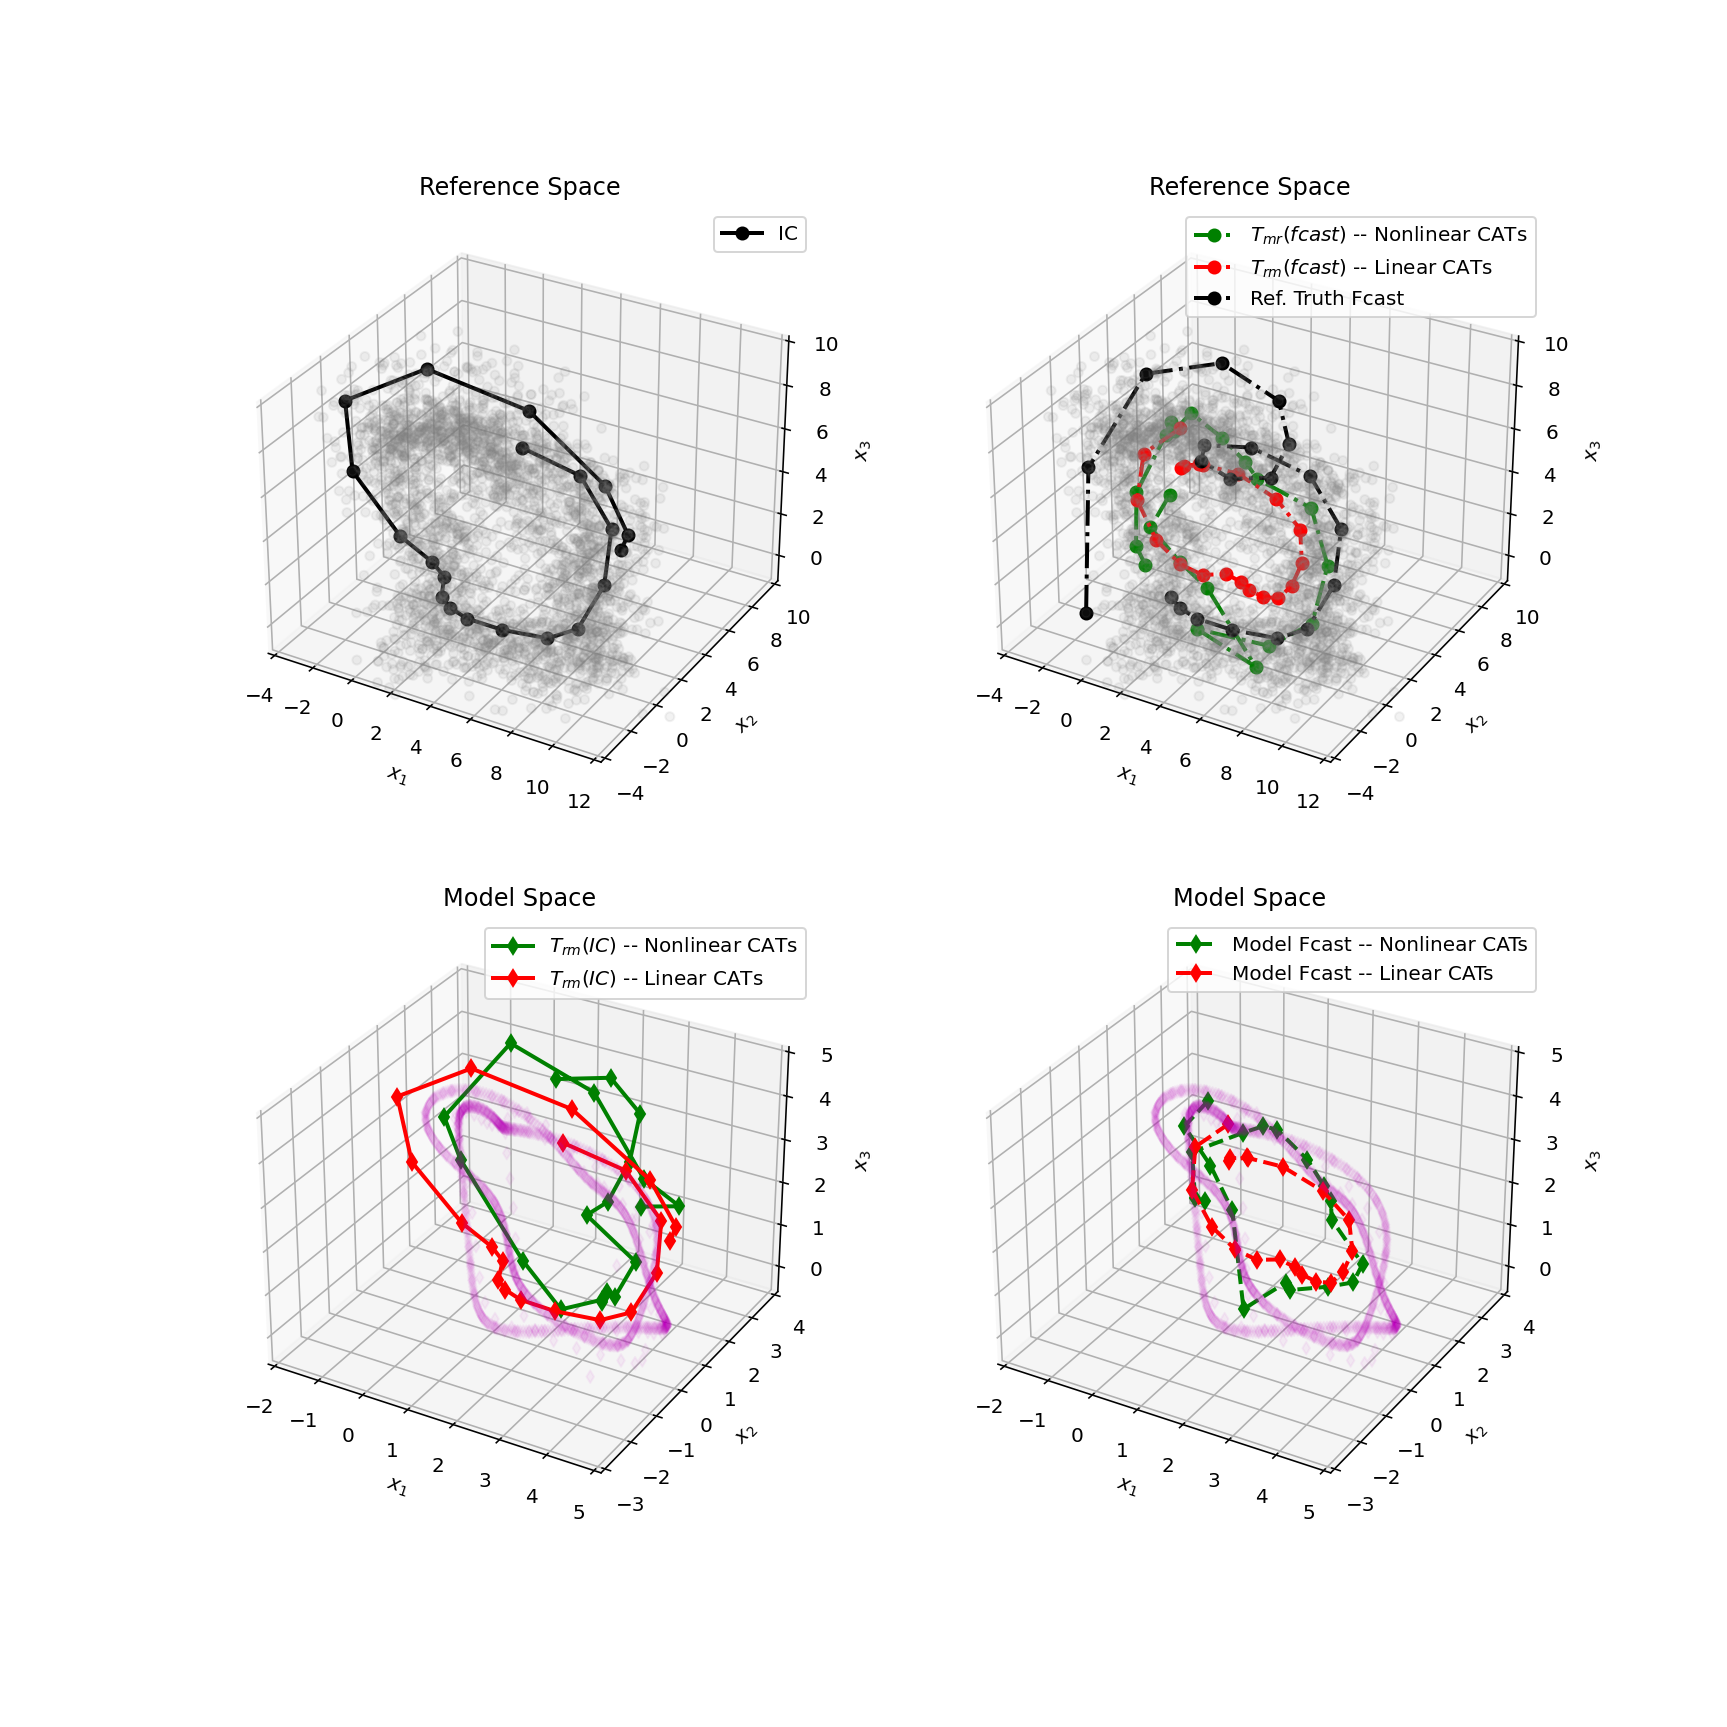

Out1 shape: (None, 8)
Shape of out2: (None, 8)
Shape of out3: (None, 8)
Out1 shape: (None, 8)
Shape of out2: (None, 8)
Shape of out3: (None, 8)


In [44]:
%matplotlib notebook
ts = 900
npoints = 20
ics = states_twolevel[ts:ts+npoints,:]
normalized_ics = scaler.transform(ics)
# pass normalized inputs to cats
nonlin_cats_ics_norm = cat_l96.T_rm.predict(normalized_ics)
nonlin_cats_ics = scaler_cat0.inverse_transform(nonlin_cats_ics_norm)
lin_cats_ics_norm = cat_l96_zeroweight.T_rm.predict(normalized_ics)
lin_cats_ics = scaler_cat0.inverse_transform(lin_cats_ics_norm)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1,projection="3d")
ax.plot(ics[:,0],ics[:,1],ics[:,2],'-ok',linewidth=2,label='IC')
ax.set_title('Reference Space')
ax.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax.set_xlabel(f'$x_1$'); ax.set_ylabel(f'$x_2$'); ax.set_zlabel(f'$x_3$');
ax.legend()
ax.scatter(states_twolevel[:3000,0],states_twolevel[:3000,1],states_twolevel[:3000,2],
             color='grey',alpha=0.1)
#ax.plot(ics[:,0],ics[:,1],'--',zdir='z',alpha=0.5, zs=-1)
#ax.plot(ics[:,1],ics[:,2],'--',zdir='x',alpha=0.5, zs=-4)
#ax.plot(ics[:,0],ics[:,2],'--',zdir='y',alpha=0.5, zs=8)
ax = fig.add_subplot(2,2,3,projection="3d")
ax.plot(nonlin_cats_ics[:,0],nonlin_cats_ics[:,1],nonlin_cats_ics[:,2],'-dg',linewidth=2,label="$T_{rm}(IC)$ -- Nonlinear CATs")
ax.plot(lin_cats_ics[:,0],lin_cats_ics[:,1],lin_cats_ics[:,2],'-dr',linewidth=2,label='$T_{rm}(IC)$ -- Linear CATs')
ax.scatter(catalogue0[:1000,0],catalogue0[:1000,1],catalogue0[:1000,2],color='m',marker='d',alpha=0.05)
ax.set_xlim([-2,5]); ax.set_ylim([-3,4]); ax.set_zlim([-0.5,5]);
ax.set_title('Model Space')
ax.set_xlabel(f'$x_1$'); ax.set_ylabel(f'$x_2$'); ax.set_zlabel(f'$x_3$');
ax.legend()
#-----------------------
nonlin_cats_fcast_norm = cat_l96.model_fcast.predict(nonlin_cats_ics_norm)
nonlin_cats_fcast = scaler_cat1.inverse_transform(nonlin_cats_fcast_norm)
lin_cats_fcast_norm = cat_l96_zeroweight.model_fcast.predict(lin_cats_ics_norm)
lin_cats_fcast = scaler_cat1.inverse_transform(lin_cats_fcast_norm)
ref_truth_fcast = states_twolevel[ts+nts_fcast:ts+npoints+nts_fcast,:]
ax = fig.add_subplot(2,2,4,projection="3d")
ax.plot(nonlin_cats_fcast[:,0],nonlin_cats_fcast[:,1],nonlin_cats_fcast[:,2],'--dg',linewidth=2,label='Model Fcast -- Nonlinear CATs')
ax.plot(lin_cats_fcast[:,0],lin_cats_fcast[:,1],lin_cats_fcast[:,2],'--dr',linewidth=2,label='Model Fcast -- Linear CATs')
ax.scatter(catalogue1[:1000,0],catalogue1[:1000,1],catalogue1[:1000,2],color='m',marker='d',alpha=0.05)
ax.set_xlim([-2,5]); ax.set_ylim([-3,4]); ax.set_zlim([-0.5,5]);
ax.set_title('Model Space')
ax.set_xlabel(f'$x_1$'); ax.set_ylabel(f'$x_2$'); ax.set_zlabel(f'$x_3$');
ax.legend()
#-----------------------
nonlin_cats_remap_norm = cat_l96.T_mr.predict(nonlin_cats_fcast_norm)
nonlin_cats_remap = scaler.inverse_transform(nonlin_cats_remap_norm)
lin_cats_remap_norm = cat_l96_zeroweight.T_mr.predict(lin_cats_fcast_norm)
lin_cats_remap = scaler.inverse_transform(lin_cats_remap_norm)
ax = fig.add_subplot(2,2,2,projection="3d")
ax.plot(nonlin_cats_remap[:,0],nonlin_cats_remap[:,1],nonlin_cats_remap[:,2],'-.og',linewidth=2,label='$T_{mr}(fcast)$ -- Nonlinear CATs')
ax.plot(lin_cats_remap[:,0],lin_cats_remap[:,1],lin_cats_remap[:,2],'-.or',linewidth=2,label='$T_{rm}(fcast)$ -- Linear CATs')
ax.set_title('Reference Space')
# Reference Truth Fcast
ax.plot(ref_truth_fcast[:,0],ref_truth_fcast[:,1],ref_truth_fcast[:,2],'-.ok',linewidth=2,label='Ref. Truth Fcast')
ax.scatter(states_twolevel[:3000,0],states_twolevel[:3000,1],states_twolevel[:3000,2],
             color='grey',alpha=0.1)
ax.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);

ax.set_xlabel(f'$x_1$'); ax.set_ylabel(f'$x_2$'); ax.set_zlabel(f'$x_3$');
plt.legend()
#plt.savefig(f'CATs_linear_nonlinear_multipleIC_visualization_n_mtu={n_mtu}.jpeg',dpi=400)
plt.show()

number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
number of steps:  2
(11, 8)


<IPython.core.display.Javascript object>


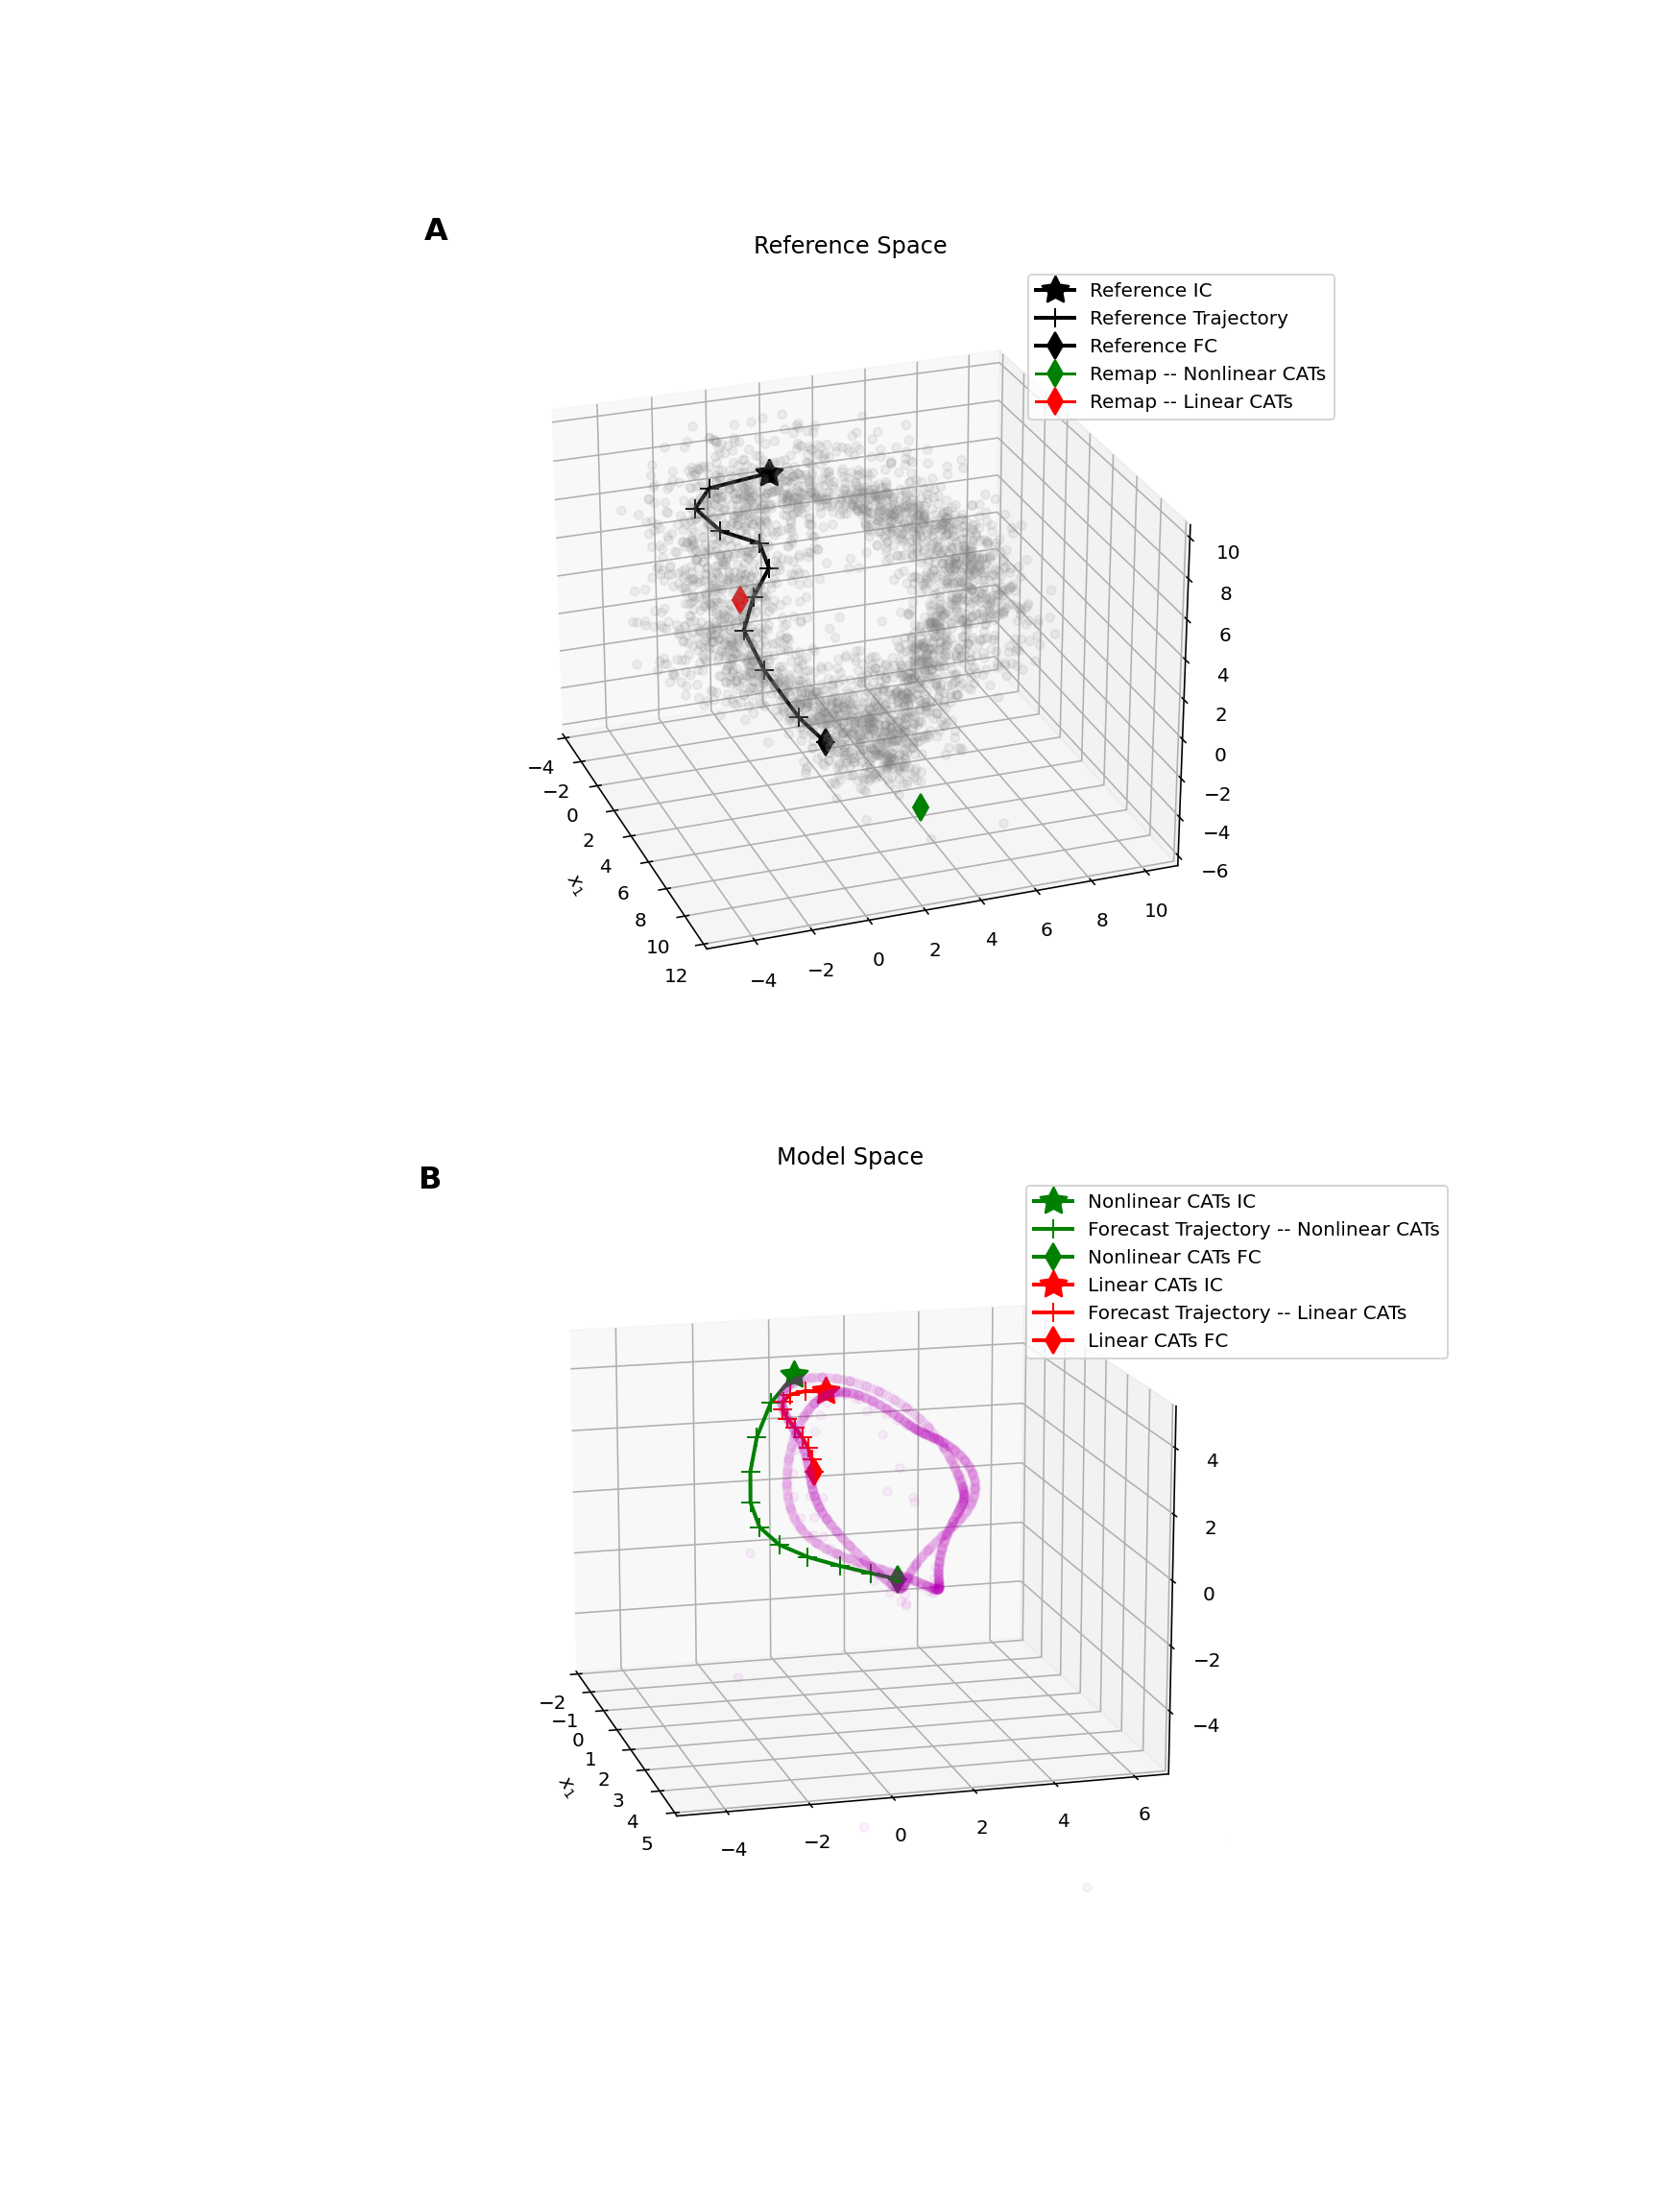

In [74]:
%matplotlib notebook
import string
ts = 210
ic = states_twolevel[n_train+ts,:]
normalized_ic = scaler.transform(ic.reshape(1,-1))

# T_rm(ic)
nonlin_cats_ic_norm = cat_l96.T_rm.predict(normalized_ic)
nonlin_cats_ic = scaler_cat0.inverse_transform(nonlin_cats_ic_norm)
lin_cats_ic_norm = cat_l96_zeroweight.T_rm.predict(normalized_ic)
lin_cats_ic = scaler_cat0.inverse_transform(lin_cats_ic_norm)

# Integrate the model forward in time
model_out_nonlin_cats = RK4(np.squeeze(nonlin_cats_ic),t_fcast,F_imp)
model_out_lin_cats = RK4(np.squeeze(lin_cats_ic),t_fcast,F_imp)
print(np.shape(model_out_nonlin_cats))

# operation: T_mr(forecasted state)
input_ = scaler_cat1.transform(model_out_nonlin_cats[-1,:].reshape(1,-1))
nonlin_cats_remap = scaler.inverse_transform(cat_l96.T_mr.predict(input_))
input_ = scaler_cat1.transform(model_out_lin_cats[-1,:].reshape(1,-1))
lin_cats_remap = scaler.inverse_transform(cat_l96_zeroweight.T_mr.predict(input_))

# Plot
fig = plt.figure(figsize=(12,16))
ax1 = fig.add_subplot(2,1,1,projection="3d")

#----------------------------------

# Reference IC
ax1.plot(ic[0],ic[1],ic[2],'-k',marker=(5,1),linewidth=2,label='Reference IC',
        markersize=15)
# Reference trajectory
ax1.plot(states_twolevel[ts+n_train:ts+n_train+nts_fcast+1,0],
        states_twolevel[ts+n_train:ts+nts_fcast+n_train+1,1],
        states_twolevel[ts+n_train:ts+nts_fcast+n_train+1,2],'-+k',linewidth=2,
        label='Reference Trajectory',markersize=10)
# Reference Final Condition
ax1.plot(states_twolevel[ts+n_train+nts_fcast,0],
        states_twolevel[ts+nts_fcast+n_train,1],
        states_twolevel[ts+nts_fcast+n_train,2],'-kd',linewidth=2,
        label='Reference FC', markersize=10)
# Remapped Position -- Nonlinear CATs
ax1.plot(nonlin_cats_remap[:,0],nonlin_cats_remap[:,1],nonlin_cats_remap[:,2],'-dg',
        label='Remap -- Nonlinear CATs',markersize=10)
# Remapped Position -- Linear CATs
ax1.plot(lin_cats_remap[:,0],lin_cats_remap[:,1],lin_cats_remap[:,2],'-dr',
        label='Remap -- Linear CATs',markersize=10)
# Attractor Space
ax1.scatter(states_twolevel[:3000,0],states_twolevel[:3000,1],
           states_twolevel[:3000,2],color='grey',alpha=0.1)
ax1.set_title('Reference Space')
ax1.set_xlim([-4,12]); ax.set_ylim([-4,10]); ax.set_zlim([-1,10]);
ax1.set_xlabel(f'$x_1$'); ax.set_ylabel(f'$x_2$'); ax.set_zlabel(f'$x_3$');
ax1.view_init(azim=-20,elev=25)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper right')
ax1.text(-4, -10, 20, string.ascii_uppercase[0], size=16, weight='bold')

#----------------------------------

ax2 = fig.add_subplot(2,1,2,projection="3d")
ax2.plot(nonlin_cats_ic[:,0],nonlin_cats_ic[:,1],nonlin_cats_ic[:,2],'-g',
        marker=(5,1),linewidth=2,label="Nonlinear CATs IC",markersize=15)
ax2.plot(model_out_nonlin_cats[:,0],model_out_nonlin_cats[:,1],
        model_out_nonlin_cats[:,2],'-+g',linewidth=2,
        label="Forecast Trajectory -- Nonlinear CATs",markersize=10)
ax2.plot(model_out_nonlin_cats[-1,0],model_out_nonlin_cats[-1,1],
        model_out_nonlin_cats[-1,2],'-dg',
        linewidth=2,label="Nonlinear CATs FC",markersize=10)
ax2.plot(lin_cats_ic[:,0],lin_cats_ic[:,1],lin_cats_ic[:,2],'-r',
        marker=(5,1),linewidth=2, label="Linear CATs IC",markersize=15)
ax2.plot(model_out_lin_cats[:,0],model_out_lin_cats[:,1],
        model_out_lin_cats[:,2],'-+r',linewidth=2,
        label='Forecast Trajectory -- Linear CATs',markersize=10)
ax2.plot(model_out_lin_cats[-1,0],model_out_lin_cats[-1,1],
        model_out_lin_cats[-1,2],'-dr',linewidth=2,label='Linear CATs FC',
        markersize=10)
ax2.scatter(states_onelevel[:1000,0],states_onelevel[:1000,1],
           states_onelevel[:1000,2],color='m',marker='o',alpha=0.05)
ax2.set_title('Model Space')
ax2.set_xlim([-2,5]); ax2.set_ylim([-3,4]); ax2.set_zlim([-0.5,5]);
ax2.set_xlabel(f'$x_1$'); ax.set_ylabel(f'$x_2$'); ax.set_zlabel(f'$x_3$');
ax2.legend(bbox_to_anchor=(1.3, 1), loc='upper right')
ax2.view_init(azim=-15,elev=15)
ax2.text(-2,-9,10,string.ascii_uppercase[1], size=16, weight='bold')
#plt.savefig(f'CATs_linear_nonlinear_trajectory_visualization_n_mtu={n_mtu}.jpeg',dpi=400)
plt.show()

### State spaces with and without CATs

<IPython.core.display.Javascript object>


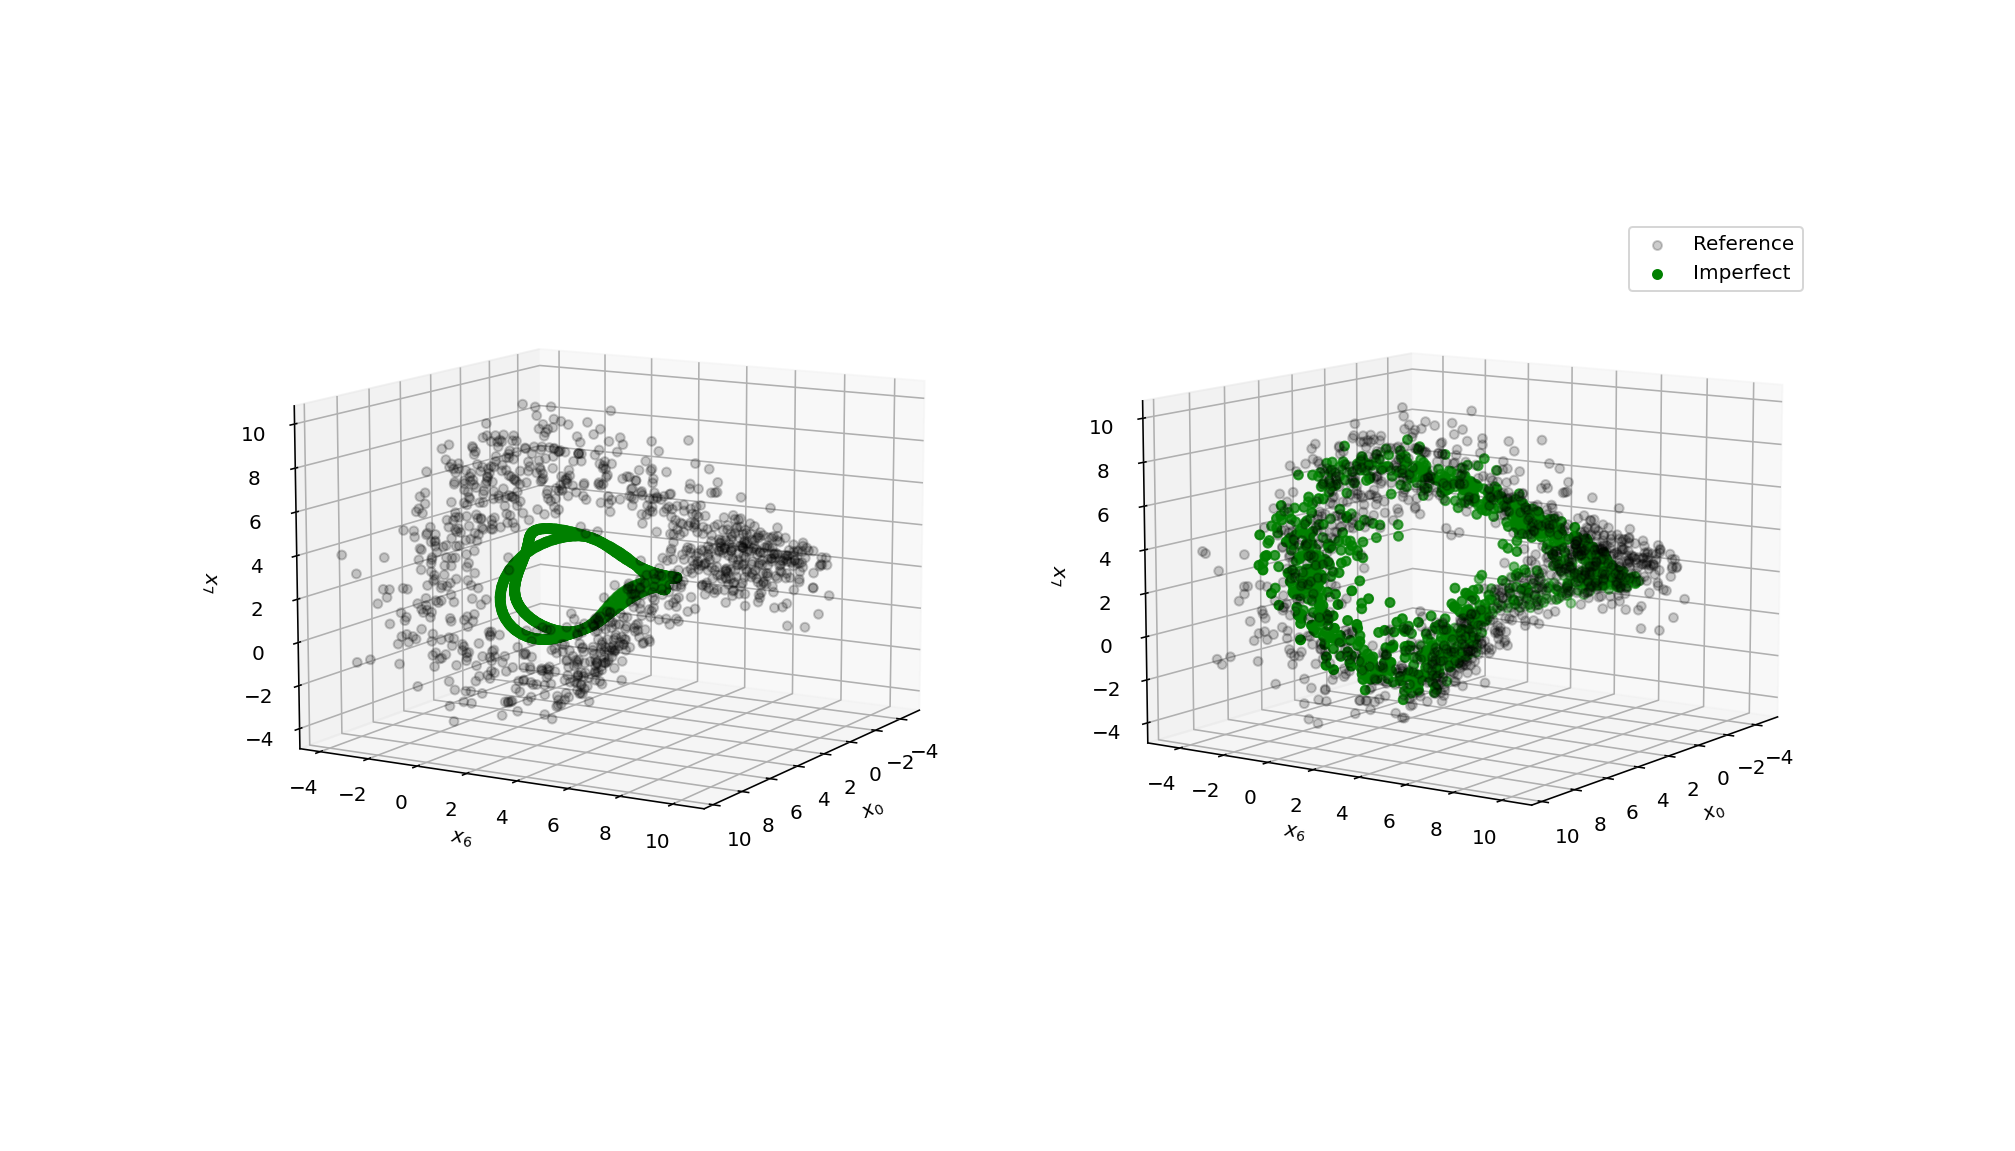

In [105]:
# Plot
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(1,2,1,projection="3d")

nic = 1000
x0=0; x1=6; x2=7
ax.scatter(states_twolevel[n_train:n_train+nic,x0],states_twolevel[n_train:n_train+nic,x1],
           states_twolevel[n_train:n_train+nic,x2],marker='o',color='k',alpha=0.2,label='Reference')
ax.scatter(states_onelevel[n_train:n_train+nic,x0],states_onelevel[n_train:n_train+nic,x1],
           states_onelevel[n_train:n_train+nic,x2],marker='o',color='g',label='Imperfect')
ax.set_xlabel(f'$x_{x0}$'); ax.set_ylabel(f'$x_{x1}$'); ax.set_zlabel(f'$x_{x2}$');

ax = fig.add_subplot(1,2,2,projection='3d')
ax.scatter(states_twolevel[n_train+nts_fcast:n_train+nts_fcast+nic,x0],
           states_twolevel[n_train+nts_fcast:n_train+nts_fcast+nic,x1],
           states_twolevel[n_train+nts_fcast:n_train+nts_fcast+nic,x2],marker='o',
           color='k',alpha=0.2,label='Reference')
ax.scatter(states_ANN_scaled[:nic,x0],states_ANN_scaled[:nic,x1],states_ANN_scaled[:nic,x2],
           marker='o',color='g',label='Imperfect')
ax.set_xlabel(f'$x_{x0}$'); ax.set_ylabel(f'$x_{x1}$'); ax.set_zlabel(f'$x_{x2}$');
plt.legend()
#plt.savefig(f'State_space_x{x0}-x{x1}-x{x2}.png',dpi=400)
plt.show()


### Estimating the lower bound for forecast error -- using ICs with errors on machine precision

In [37]:
n_mtu_arr = np.linspace(0.2,2,10) # lead time in model time units
n_mtu_arr = np.insert(n_mtu_arr,0,0.1)
rmse_lbound = np.zeros(11) # lower bound of RMSE
mp_error = np.random.normal(0,1e-14) # machine precision error

for l in range(len(n_mtu_arr)):
    n_mtu_local = n_mtu_arr[l]
    nts_forward = round(n_mtu_local/dt_fcast)
    print('Lead time:',n_mtu_local)
    print('Lead time steps:',nts_forward)
    n_tot = 10000-nts_forward
    n_train = round(n_tot*0.8) # change 0.8 to whatever training vs test ratio used in the training
    n_test = n_tot-n_train  
    t_fcast_local = np.linspace(0,n_mtu_local,nts_forward+1)
    print('time array:',t_fcast_local)
    fcast_ = np.zeros((n_test,K+J*K))
    
    for kk in range(n_test):
        ic_ = states_twolevel[n_train+kk] + mp_error
        fc_ = odeint(L96_twolevel,ic_,t_fcast_local,args=args_twolevel)[-1,:]
        fcast_[kk,:] = fc_    
    
    rmse_lbound[l] = np.sqrt(np.mean((states_twolevel[n_train+nts_forward:n_train+nts_forward+n_test,:K]-
                                                  fcast_[:,:K])**2))
    del fcast_
    gc.collect()
    
print('RMSE lower bound',rmse_lbound)

Lead time: 0.1
Lead time steps: 1
time array: [0.  0.1]
Lead time: 0.2
Lead time steps: 2
time array: [0.  0.1 0.2]
Lead time: 0.4
Lead time steps: 4
time array: [0.  0.1 0.2 0.3 0.4]
Lead time: 0.6000000000000001
Lead time steps: 6
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6]
Lead time: 0.8
Lead time steps: 8
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
Lead time: 1.0
Lead time steps: 10
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Lead time: 1.2
Lead time steps: 12
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2]
Lead time: 1.4000000000000001
Lead time steps: 14
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4]
Lead time: 1.6
Lead time steps: 16
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6]
Lead time: 1.8
Lead time steps: 18
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8]
Lead time: 2.0
Lead time steps: 20
time array: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 

### Lead time vs RMSE plot 

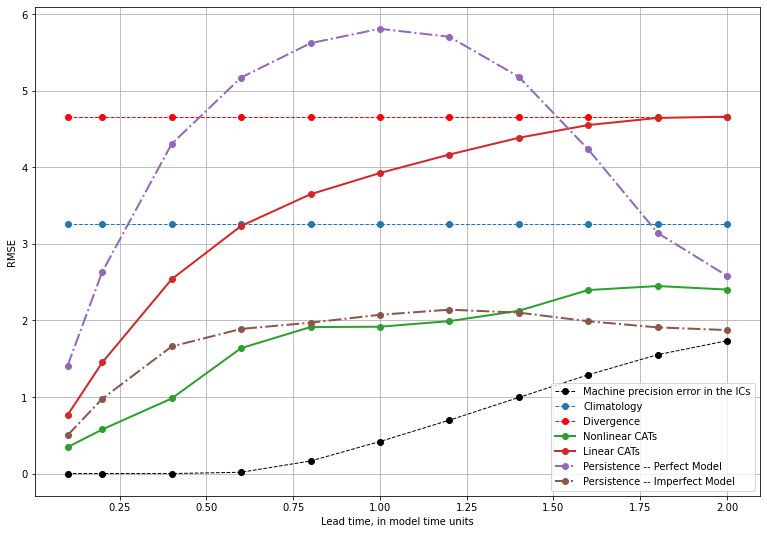

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(13,9))
# lead time in model time units
n_mtu_arr = np.linspace(0.2,2,10)
n_mtu_arr = np.insert(n_mtu_arr,0,0.1)

# RMSEs
#rmse_nonlin_cats = np.array([0.1907,0.3238,0.6077,1.2441,1.6380,
#                             1.74620,1.9218,2.03,2.1808,2.28,2.2737])
#rmse_lin_cats = np.array([0.7630,1.449,2.5343,3.2294,3.64566,3.9238,
#                          4.1630,4.3791,4.5427,4.6334,4.6500])
rmse_nonlin_cats = np.array([0.3443,0.5757,0.9804,1.6376,1.9126,1.9173,
                             1.990,2.1251,2.3957,2.4484,2.4022])
rmse_lin_cats = np.array([0.7632,1.4501,2.5375,3.2326,3.6465,3.9239,
                          4.1650,4.3840,4.550,4.6432,4.6598])
rmse_persist_perfect = np.array([1.4071,2.6341,4.3042,5.1704,5.6193,
                                 5.807,5.703,5.1809,4.2326,3.1423,2.5814])
rmse_persist_imperfect = np.array([0.5,0.9769,1.6592,1.8887,1.9695,2.0733,
                                   2.1397,2.1013,1.9887,1.9085,1.8736])
rmse_mperror = np.array([2.44001142e-08, 5.07046827e-07, 1.21530879e-04, 1.70846949e-02,
 1.63760380e-01, 4.18461353e-01, 6.97336708e-01, 9.93316908e-01,
 1.28973071e+00, 1.55190788e+00, 1.73394067e+00])
rmse_divergence = np.repeat(4.65,[11,])
rmse_clima = np.repeat(3.26,[11,])

# plot
plt.plot(n_mtu_arr,rmse_lbound,'--ok',linewidth=1,label='Machine precision error in the ICs')
plt.plot(n_mtu_arr,rmse_clima,'--oC0',linewidth=1,label='Climatology')
plt.plot(n_mtu_arr,rmse_divergence,'--or',linewidth=1,label='Divergence')

plt.plot(n_mtu_arr,rmse_nonlin_cats,'-oC2',linewidth=2,label='Nonlinear CATs')
plt.plot(n_mtu_arr,rmse_lin_cats,'-oC3',linewidth=2,label='Linear CATs')
plt.plot(n_mtu_arr,rmse_persist_perfect,'-.oC4',linewidth=2,label='Persistence -- Perfect Model')
plt.plot(n_mtu_arr,rmse_persist_imperfect,'-.oC5',linewidth=2,label='Persistence -- Imperfect Model')


plt.legend()
plt.xlabel('Lead time, in model time units')
plt.ylabel('RMSE')
plt.grid()
plt.savefig('Lead_time_vs_RMSE_Nonlinear_Linear_CATs_1HL-10Neurons.jpeg',dpi=400)
plt.show()